# Separate Light profile

#### First import modules ####

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting

from dysmalpy.fitting_wrappers import tied_functions

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook #####

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

In [4]:
from importlib import reload

-----------

## Gaussian Ring: If flux profile right?

In [5]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [6]:
GR = models.LightGaussianRing(r_peak=5., sigma_r =1., L_tot=1.)

In [7]:
r = np.arange(0.,20.1,0.1)

In [8]:
Lr = GR(r)

In [9]:
np.sum(2.*np.pi*r*Lr*(r[1]-r[0]))

0.9999999997551636

In [10]:
I0 = models._I0_gaussring(GR.r_peak.value, GR.sigma_r.value, GR.L_tot.value)

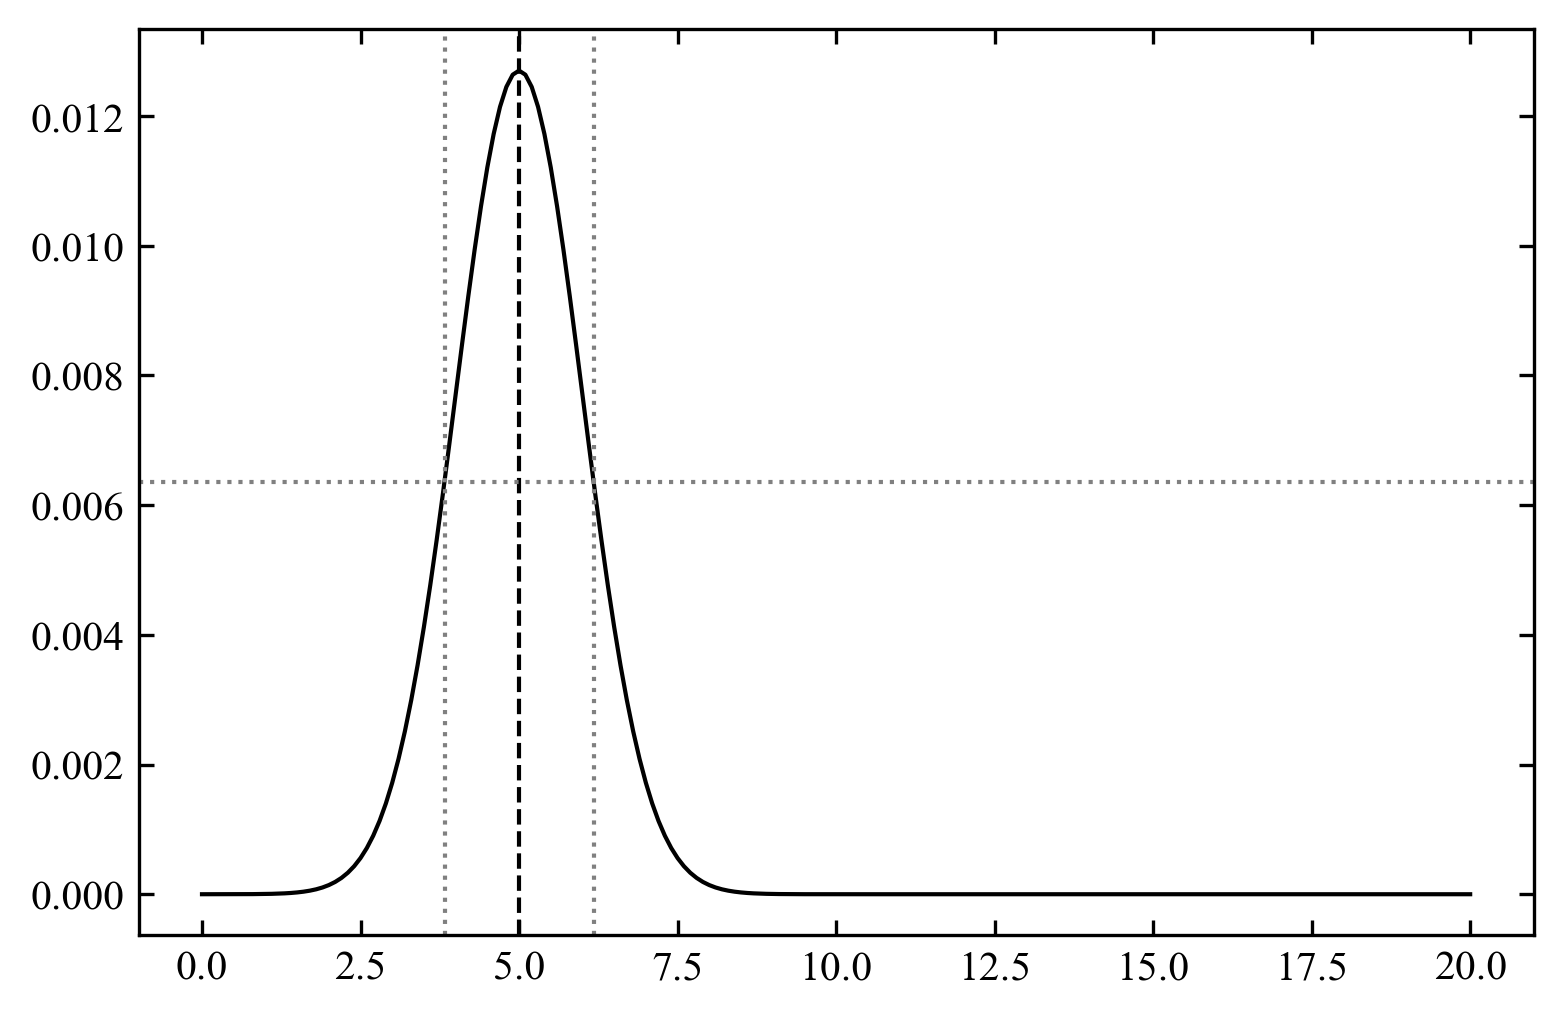

In [11]:
plt.plot(r, Lr, color='black')
plt.gca().axvline(x=GR.r_peak.value, ls='--', color='k')
plt.gca().axvline(x=GR.r_peak.value-2.35*GR.sigma_r.value/2., ls=':', color='grey')
plt.gca().axvline(x=GR.r_peak.value+2.35*GR.sigma_r.value/2., ls=':', color='grey')
plt.gca().axhline(y=0.5*I0, ls=':', color='grey')

## Truncated Sersic: If flux profile right?

In [12]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [13]:
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., r_inner=1., r_outer=10.)
Sersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1.)

In [14]:
r = np.arange(0.,20.1,0.1)

In [15]:
TLr = TSersic(r)
SLr = Sersic(r)

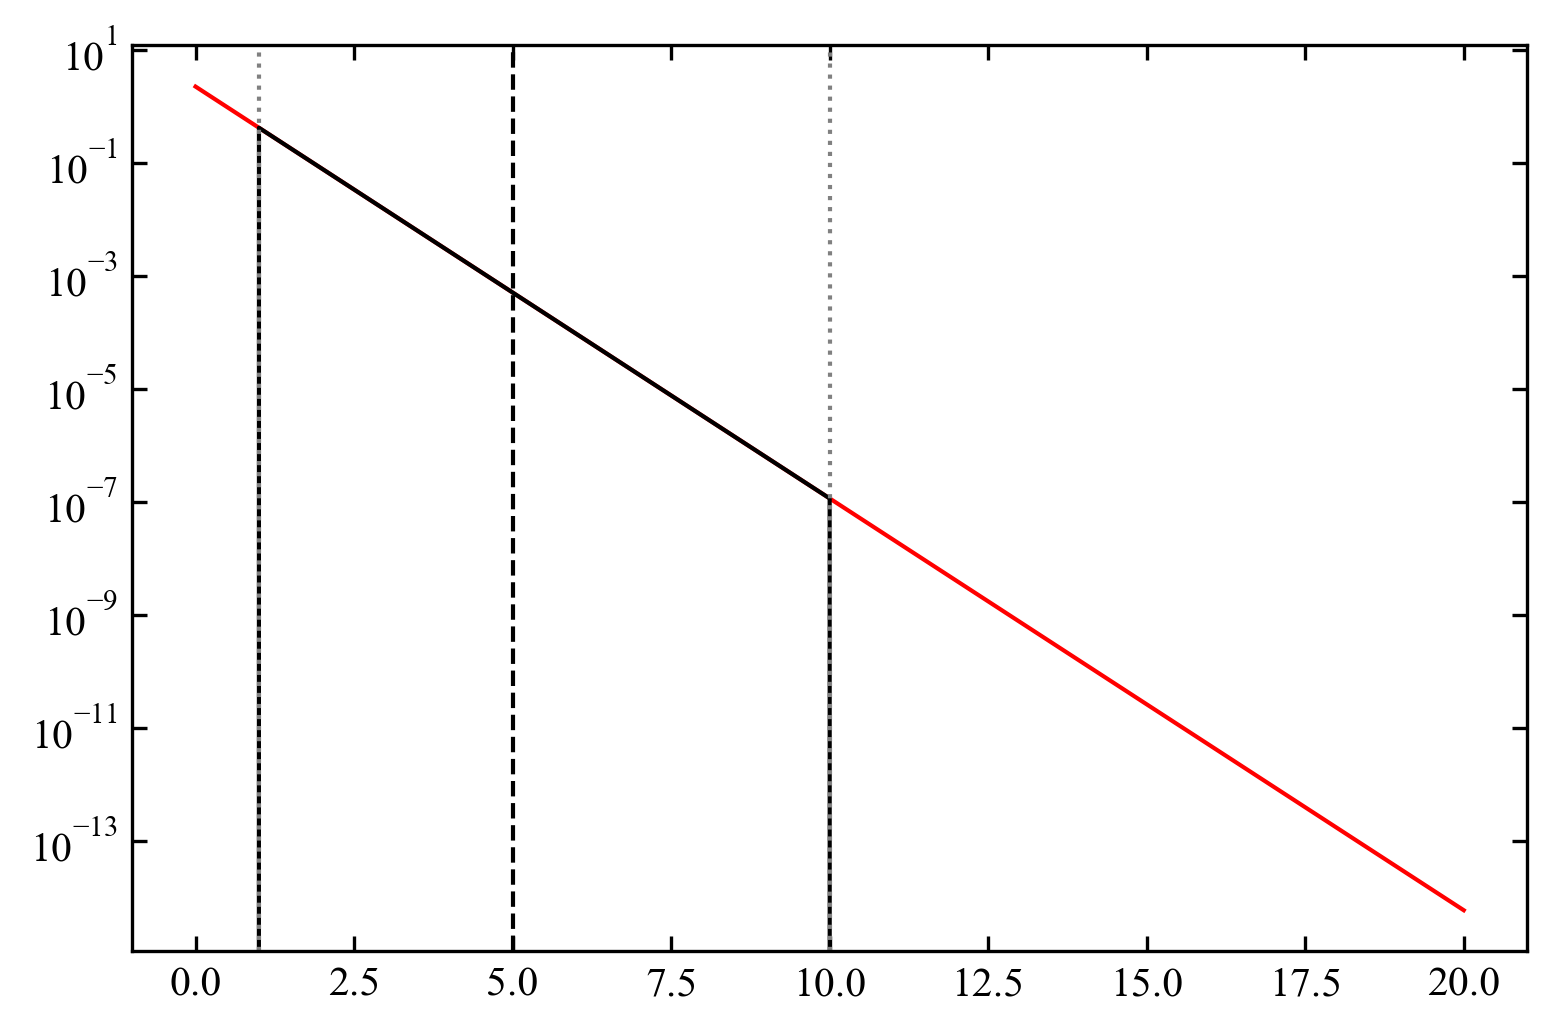

In [16]:
plt.plot(r, SLr, color='red')
plt.plot(r, TLr, color='black')
plt.gca().axvline(x=TSersic.r_eff.value, ls='--', color='k')
plt.gca().axvline(x=TSersic.r_inner.value, ls=':', color='grey')
plt.gca().axvline(x=TSersic.r_outer.value, ls=':', color='grey')
plt.gca().set_yscale('log')

In [17]:
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., r_inner=1., r_outer=10.)
Sersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1.)

In [18]:
r = np.arange(0.,20.1,0.1)

In [19]:
TLr = TSersic.mass_to_light(r)
SLr = Sersic.mass_to_light(r)

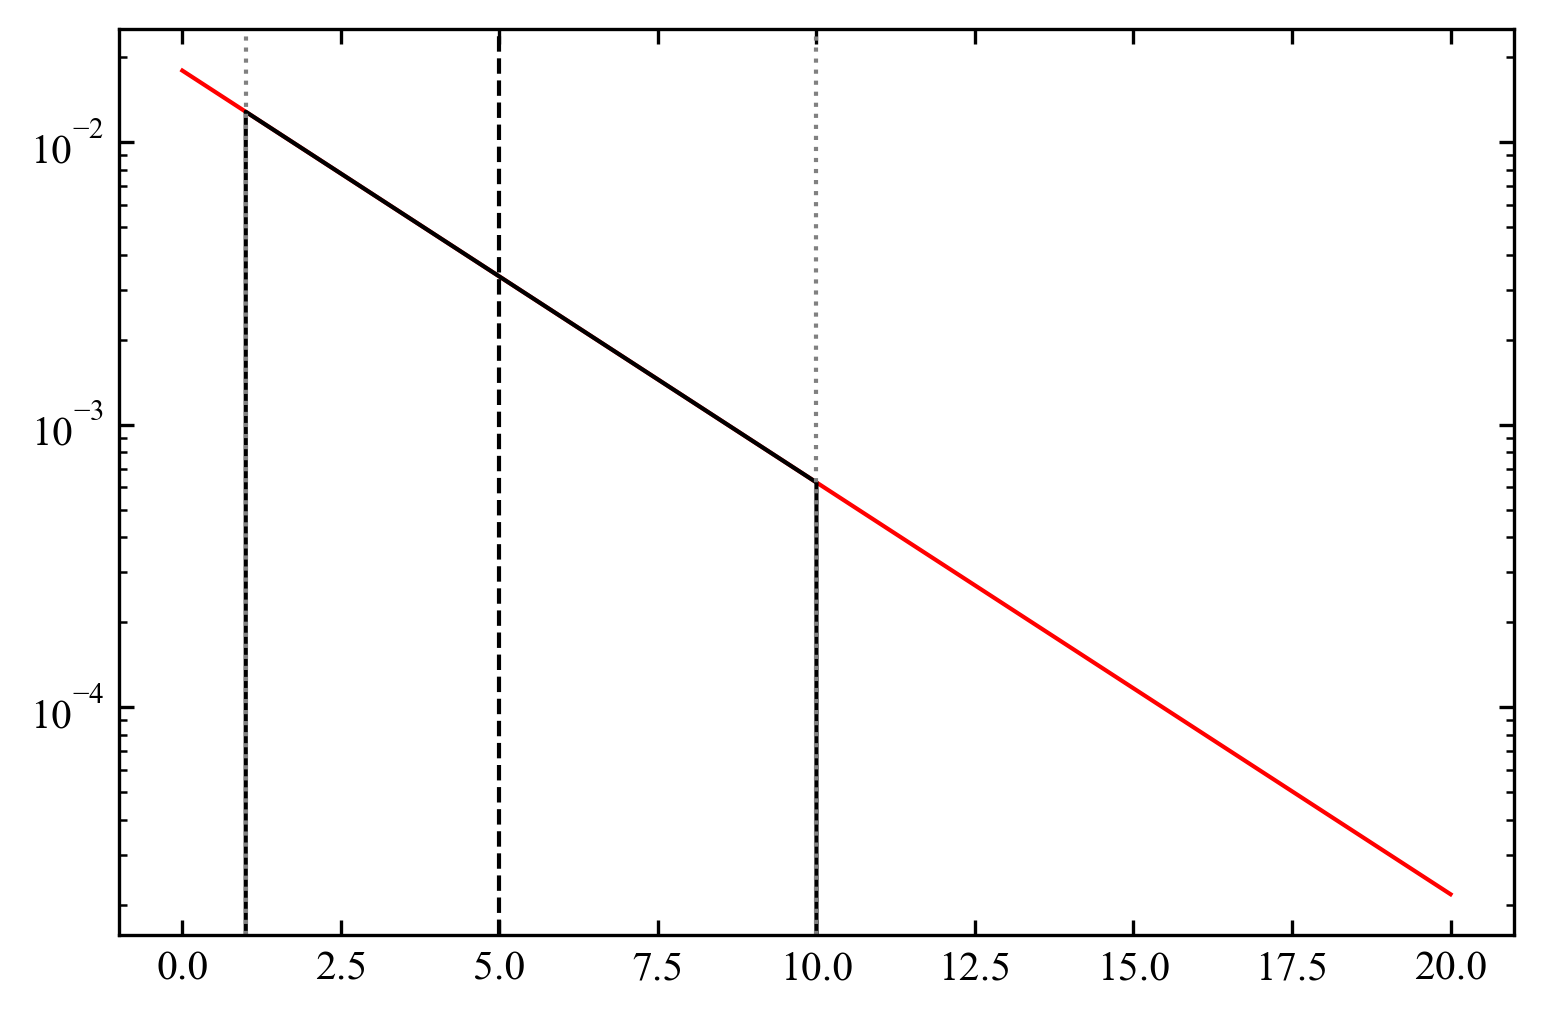

In [20]:
plt.plot(r, SLr, color='red')
plt.plot(r, TLr, color='black')
plt.gca().axvline(x=TSersic.r_eff.value, ls='--', color='k')
plt.gca().axvline(x=TSersic.r_inner.value, ls=':', color='grey')
plt.gca().axvline(x=TSersic.r_outer.value, ls=':', color='grey')
plt.gca().set_yscale('log')

## Test Mass profile vs light profile:

### Hack 1: BH with Sersic=1

In [21]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [22]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [23]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [24]:
BH = models.BlackHole(BH_mass=9.,name='BH')
LSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., name='LSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [25]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [26]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [27]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [28]:
mod_setFO.add_component(BH)
mod_setFO.add_component(LSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [29]:
mod_setEO.add_component(BH)
mod_setEO.add_component(LSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

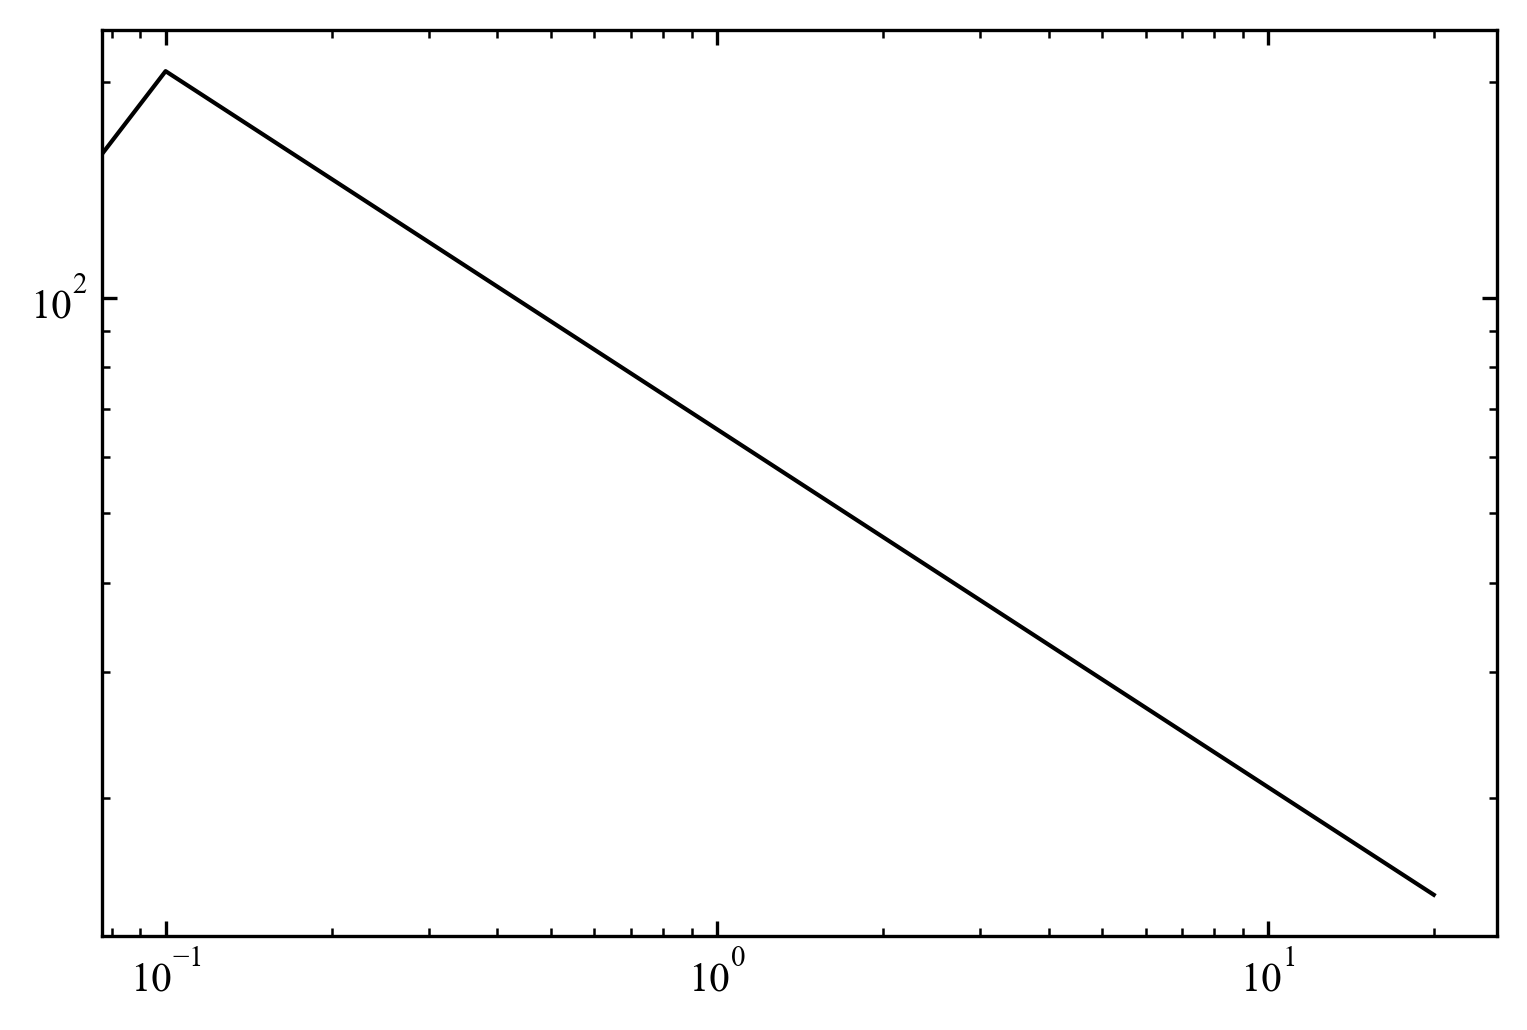

In [30]:
r = np.arange(0.,20.1,0.1)
vc = galEO.model.circular_velocity(r)
vcBH = BH.circular_velocity(r)
vc[r == 0.] = 0.
vcBH[r==0.] = 0.
plt.plot(r, vc, color='black')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

(0.0, 50.0)

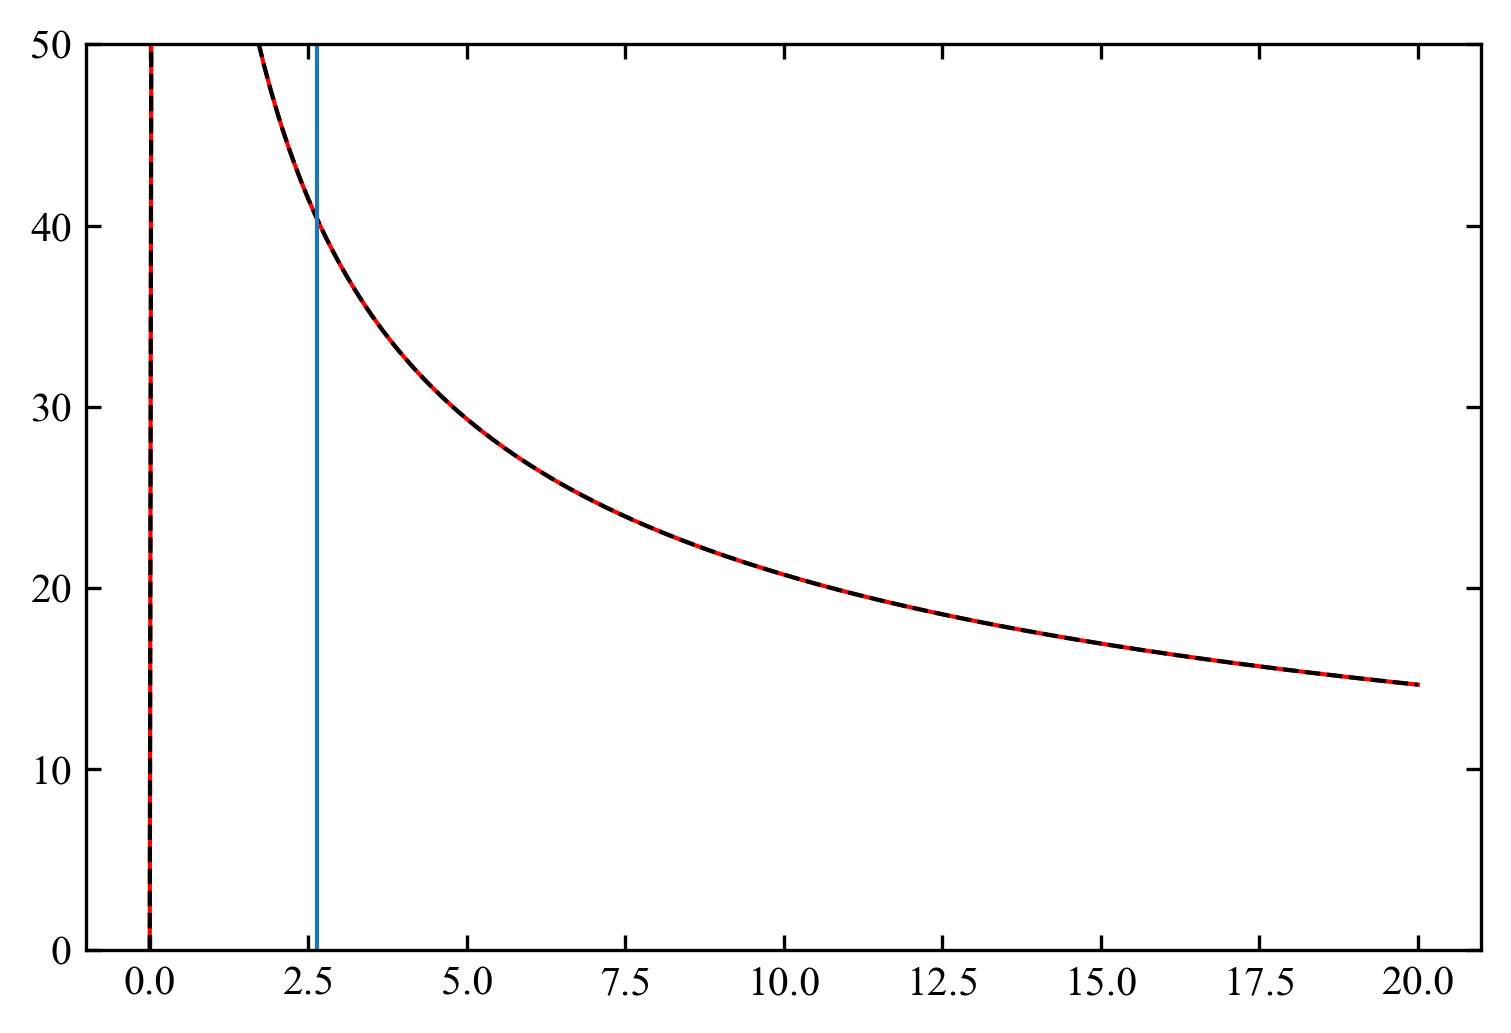

In [31]:
r = np.arange(0.,20.1,0.1)
vc = galEO.model.circular_velocity(r)
vcBH = BH.circular_velocity(r)
vc[r == 0.] = 0.
vcBH[r==0.] = 0.
plt.plot(r, vcBH, color='red')
plt.plot(r, vc, color='black', ls='--')
plt.gca().axvline(8.*0.33)
plt.gca().set_ylim([0., 50.])

In [32]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [33]:
galFO.instrument = inst
galEO.instrument = inst

In [34]:
galFO.model.light_components

OrderedDict([('BH', False),
             ('LSersic', True),
             ('dispprof', False),
             ('zheightgaus', False),
             ('geom', False)])

### 1D model

In [35]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

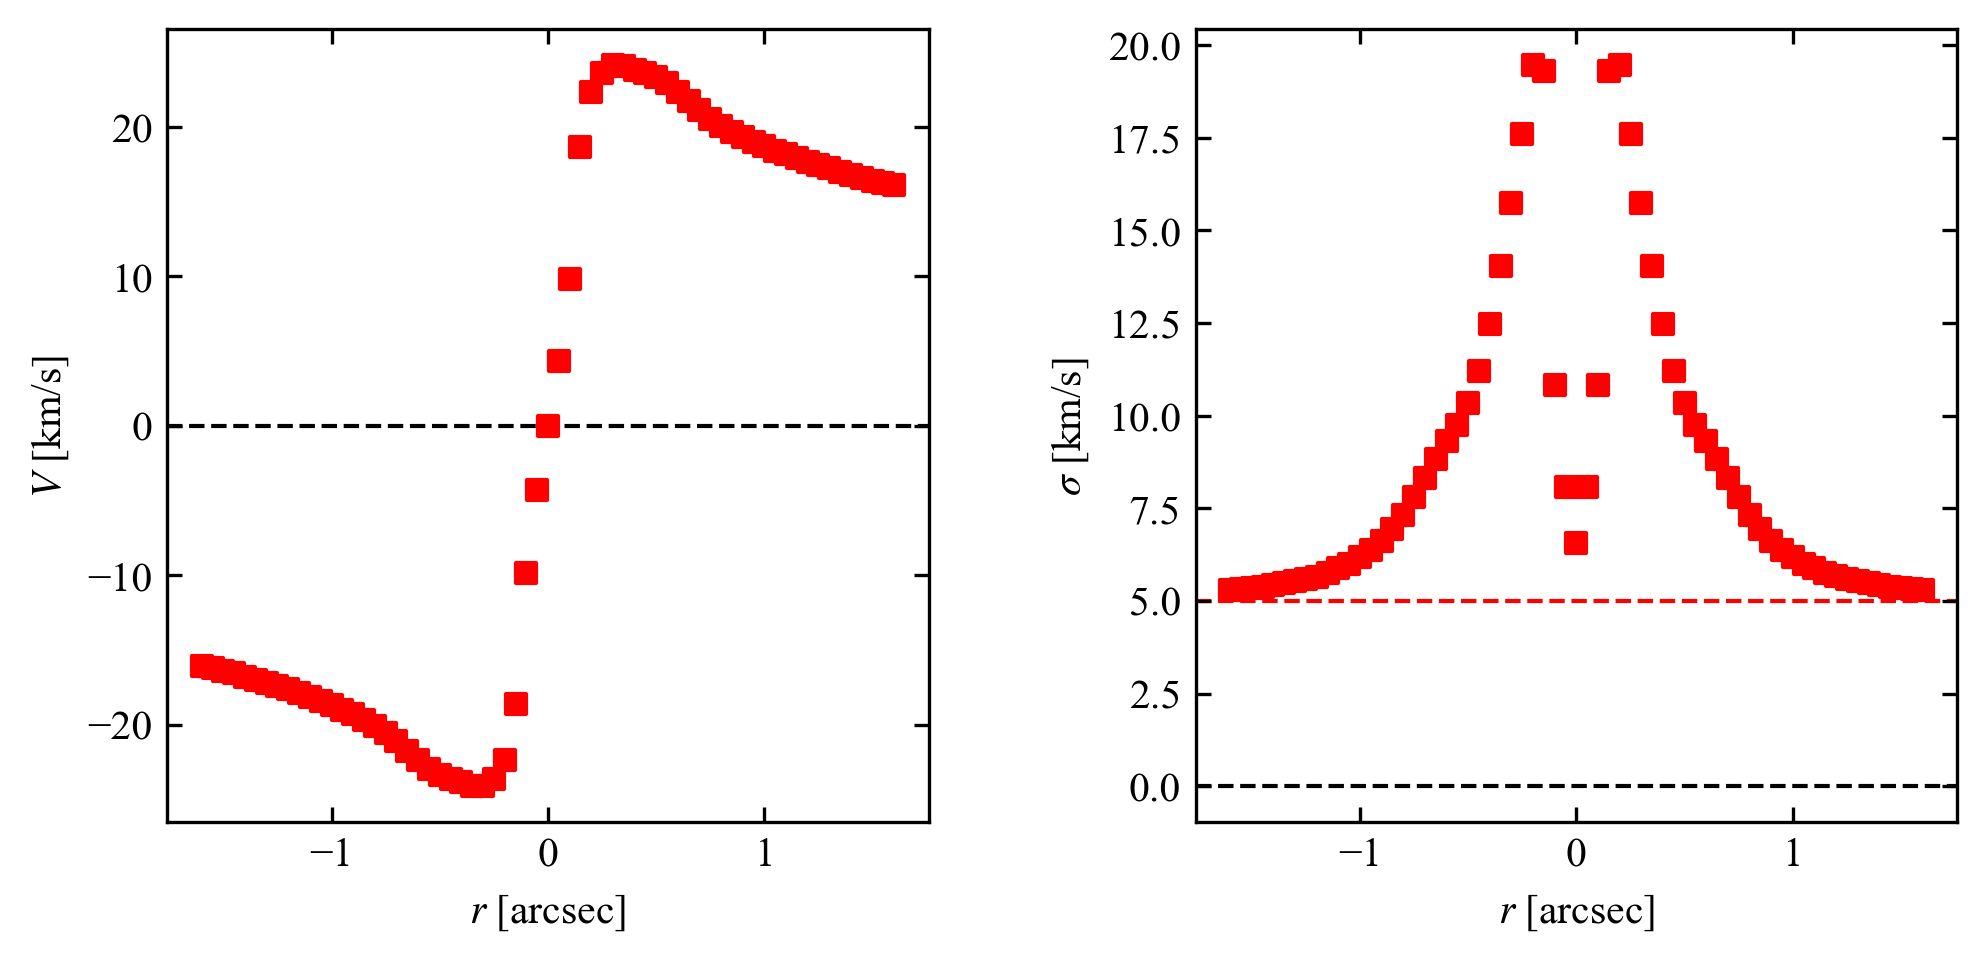

In [36]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [37]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

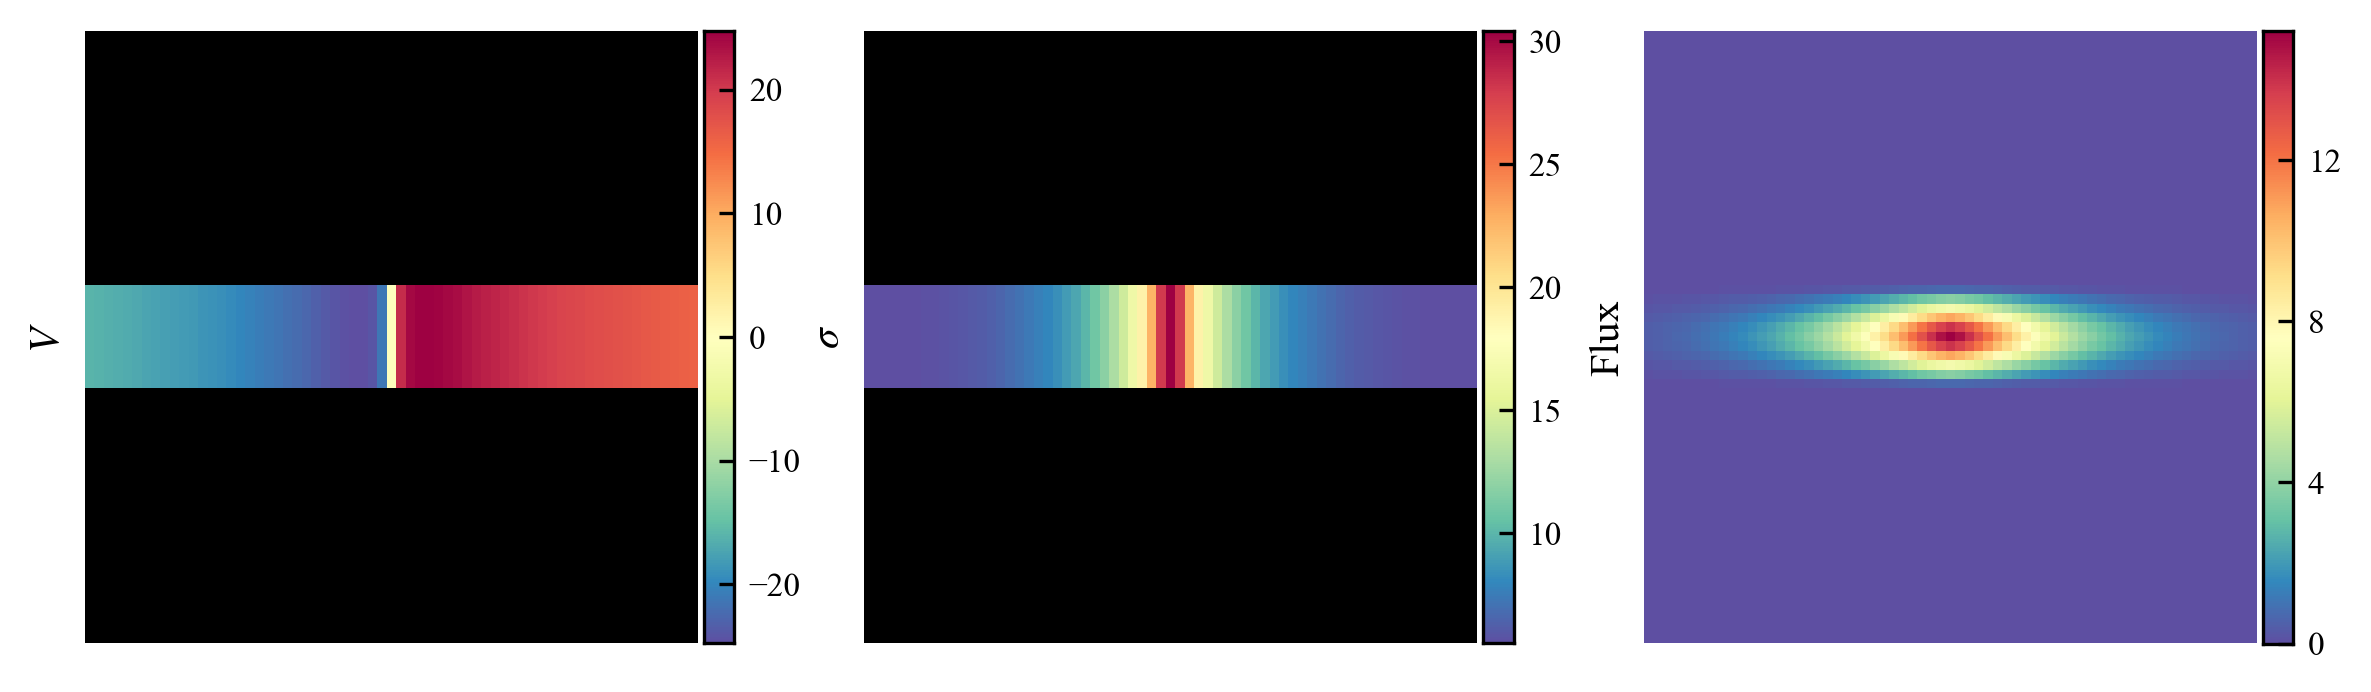

In [38]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [39]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

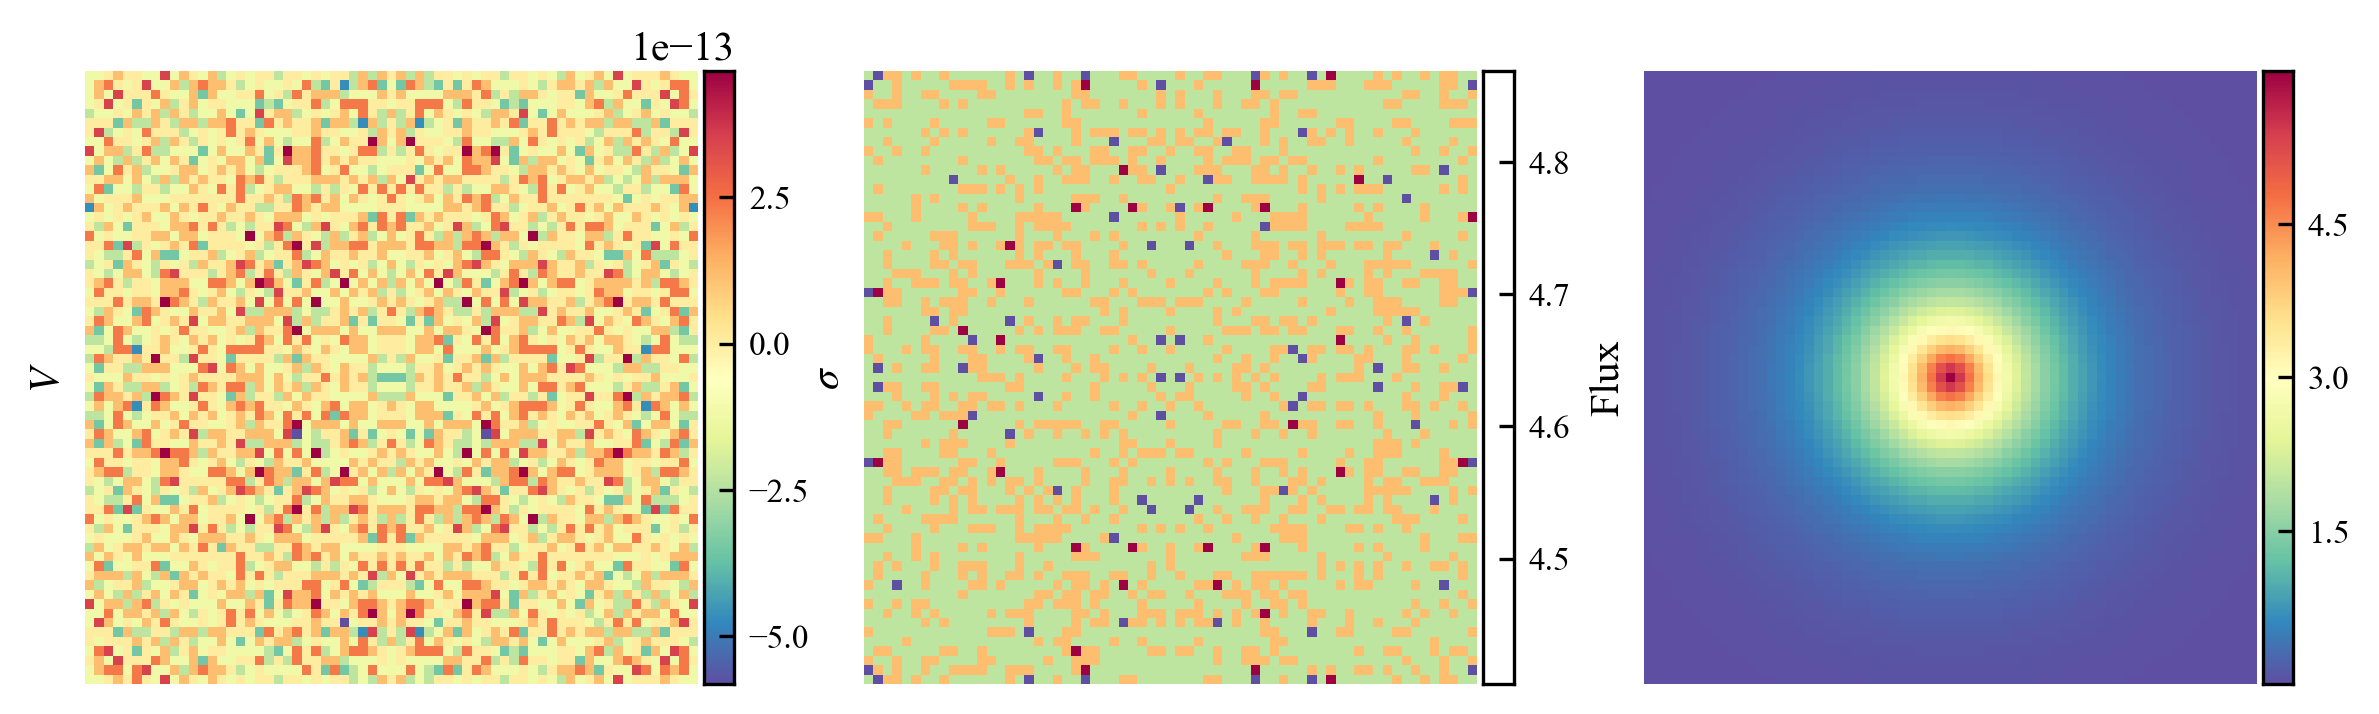

In [40]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------

### Hack 2: BH with LSersic=1, truncated

In [41]:
reload(models)
reload(galaxy)

<module 'dysmalpy.galaxy' from '/Users/sedona/software_public/dysmalpy/dysmalpy/galaxy.py'>

In [42]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [43]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [44]:
BH = models.BlackHole(BH_mass=9.,name='BH')
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., 
                                     r_inner=5., r_outer=10., name='TSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [45]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [46]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [47]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [48]:
mod_setFO.add_component(BH)
mod_setFO.add_component(TSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [49]:
mod_setEO.add_component(BH)
mod_setEO.add_component(TSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [50]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [51]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [52]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

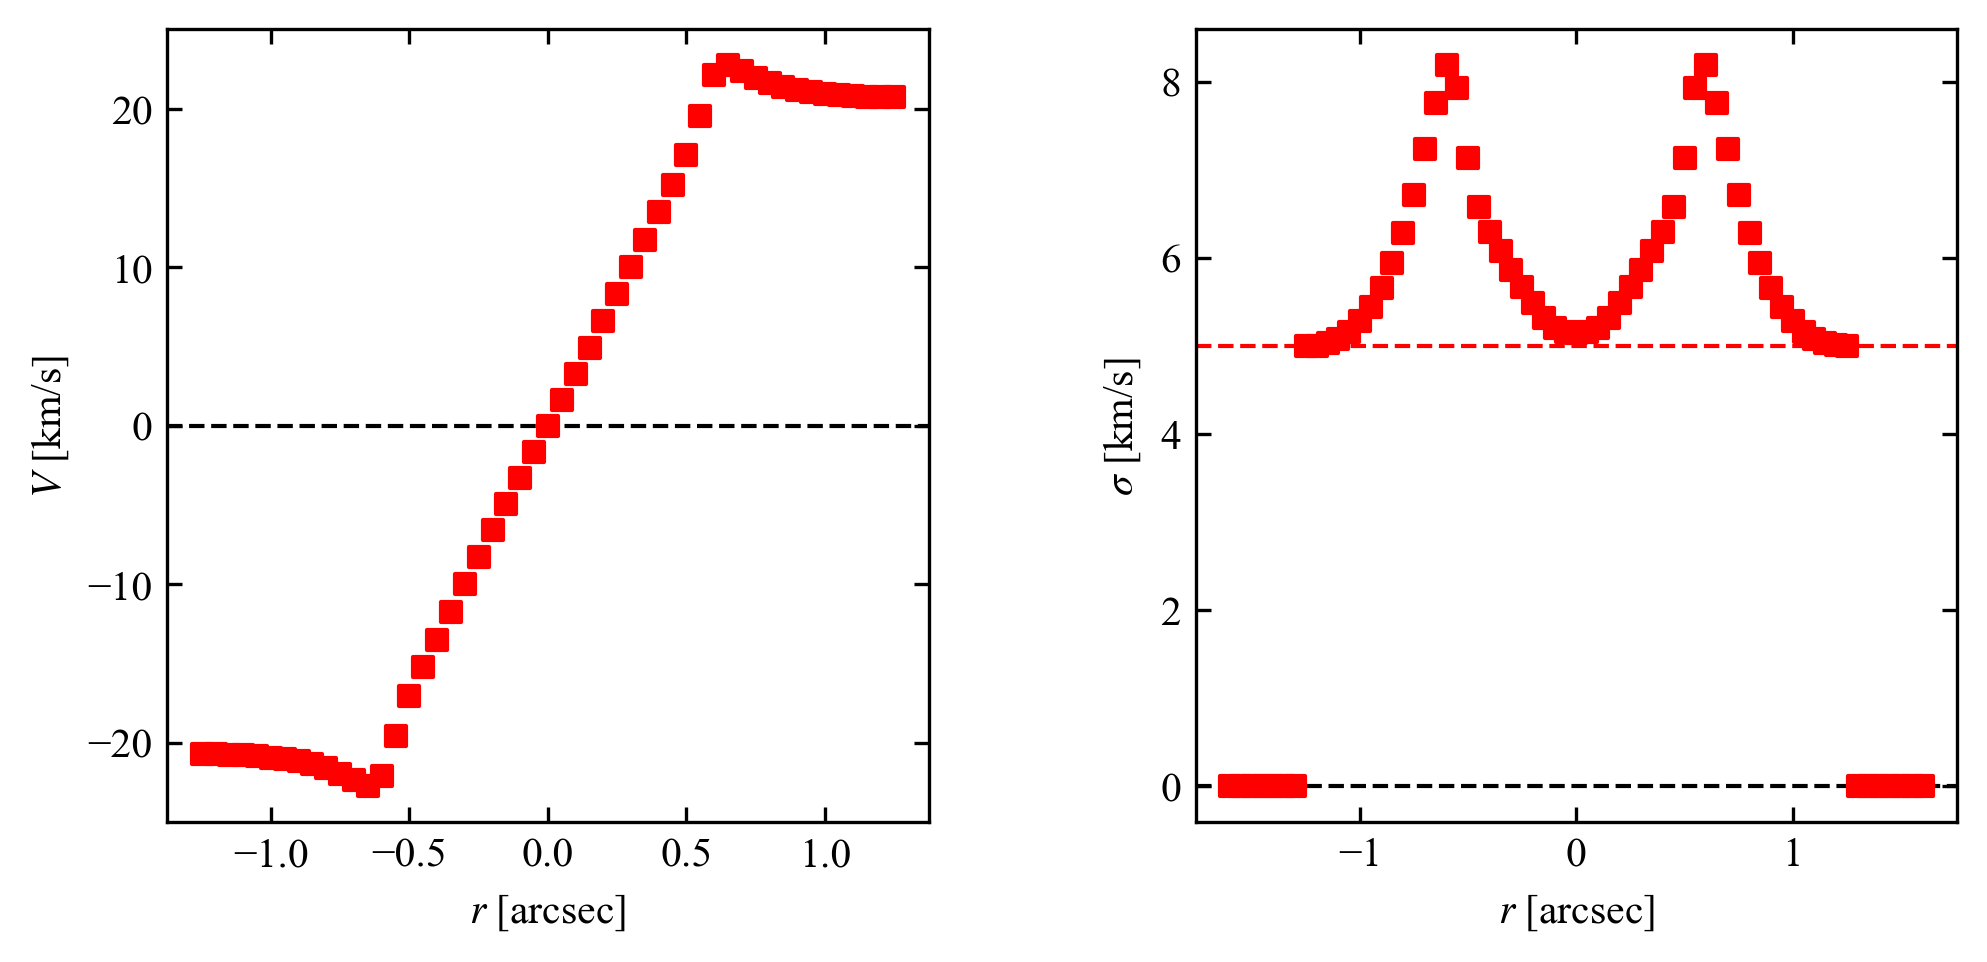

In [53]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [54]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

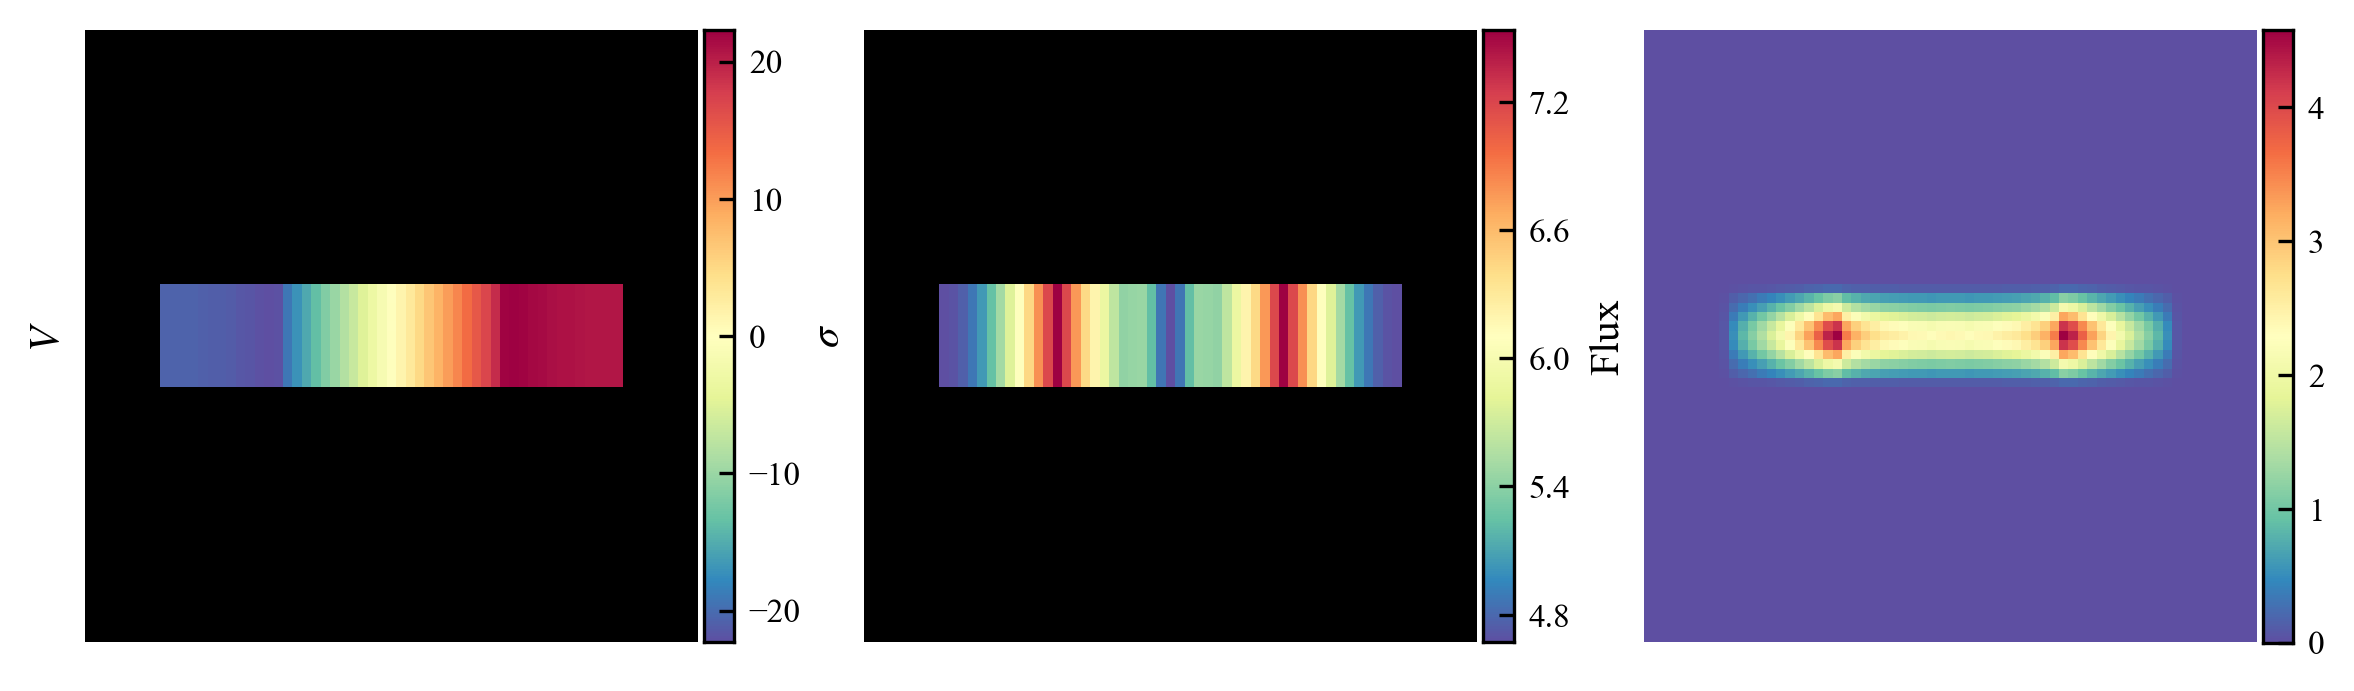

In [55]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [56]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

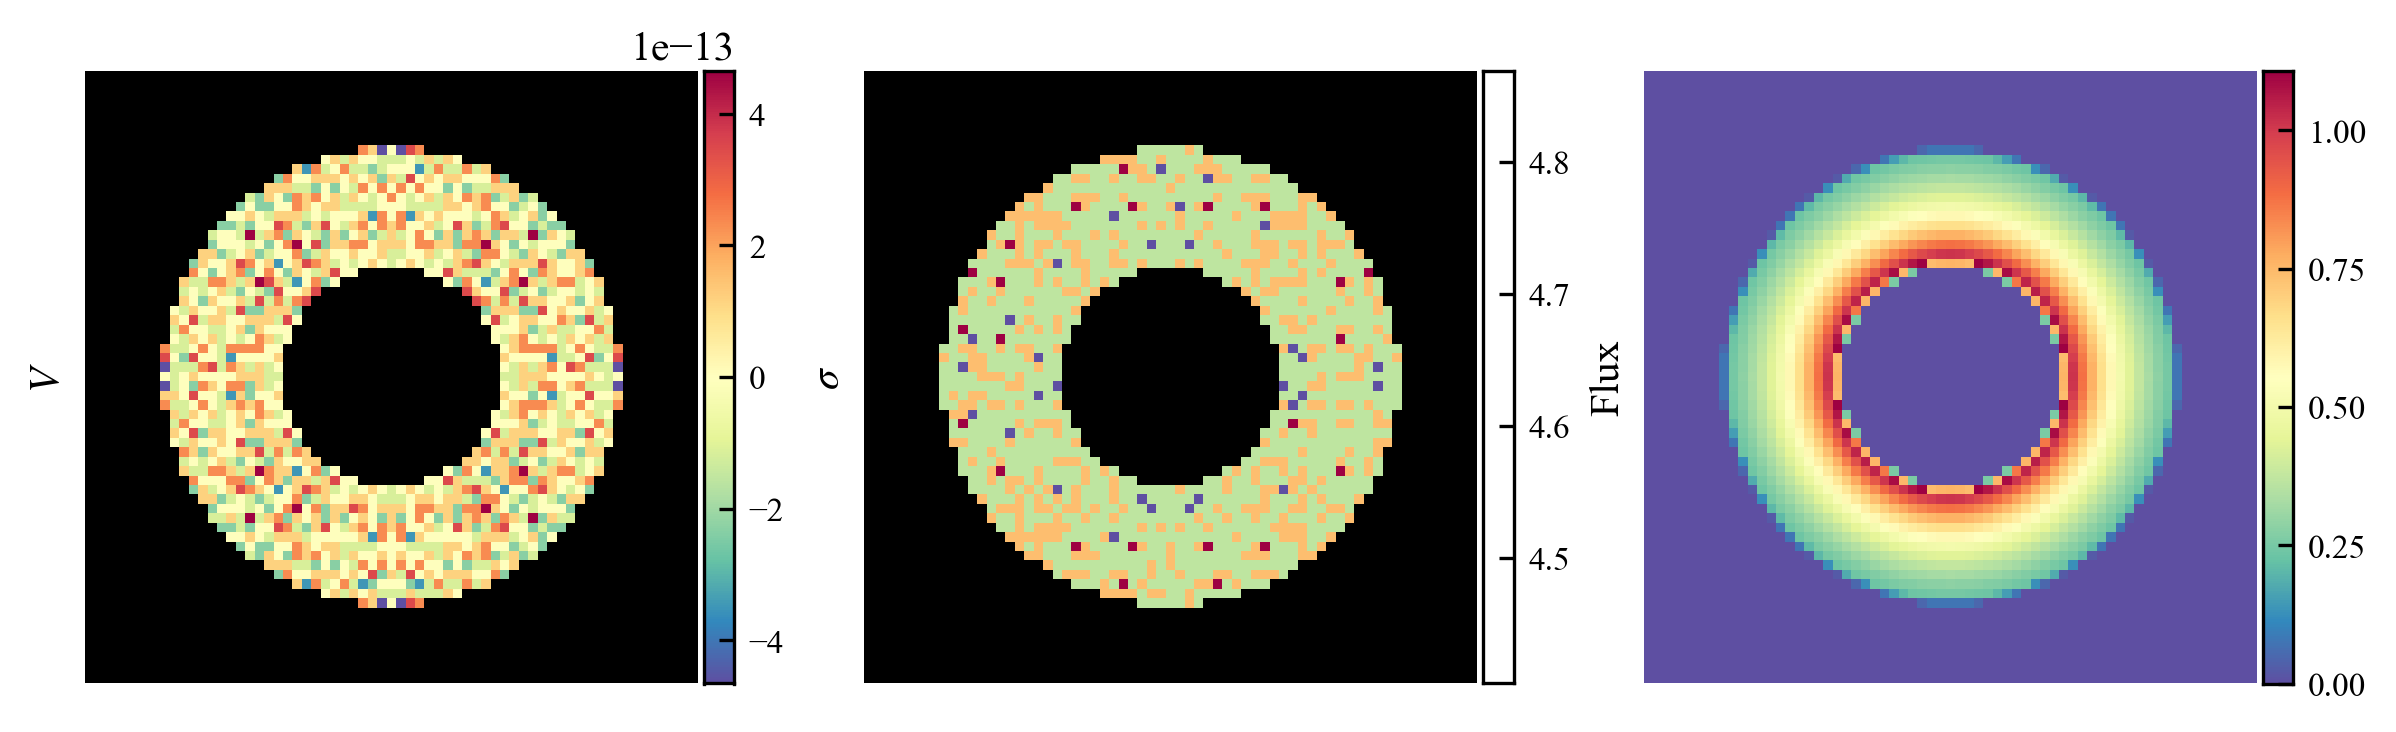

In [57]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------

### Hack 3: BH with GaussianRing

In [58]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [59]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [60]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [61]:
BH = models.BlackHole(BH_mass=9.,name='BH')
GR = models.LightGaussianRing(r_peak=5., sigma_r =1., L_tot=1., name='GaussianRing')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [62]:
sigmaz = 1.  # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [63]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [64]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [65]:
mod_setFO.add_component(BH)
mod_setFO.add_component(GR, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [66]:
mod_setEO.add_component(BH)
mod_setEO.add_component(GR, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [67]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [68]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [69]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

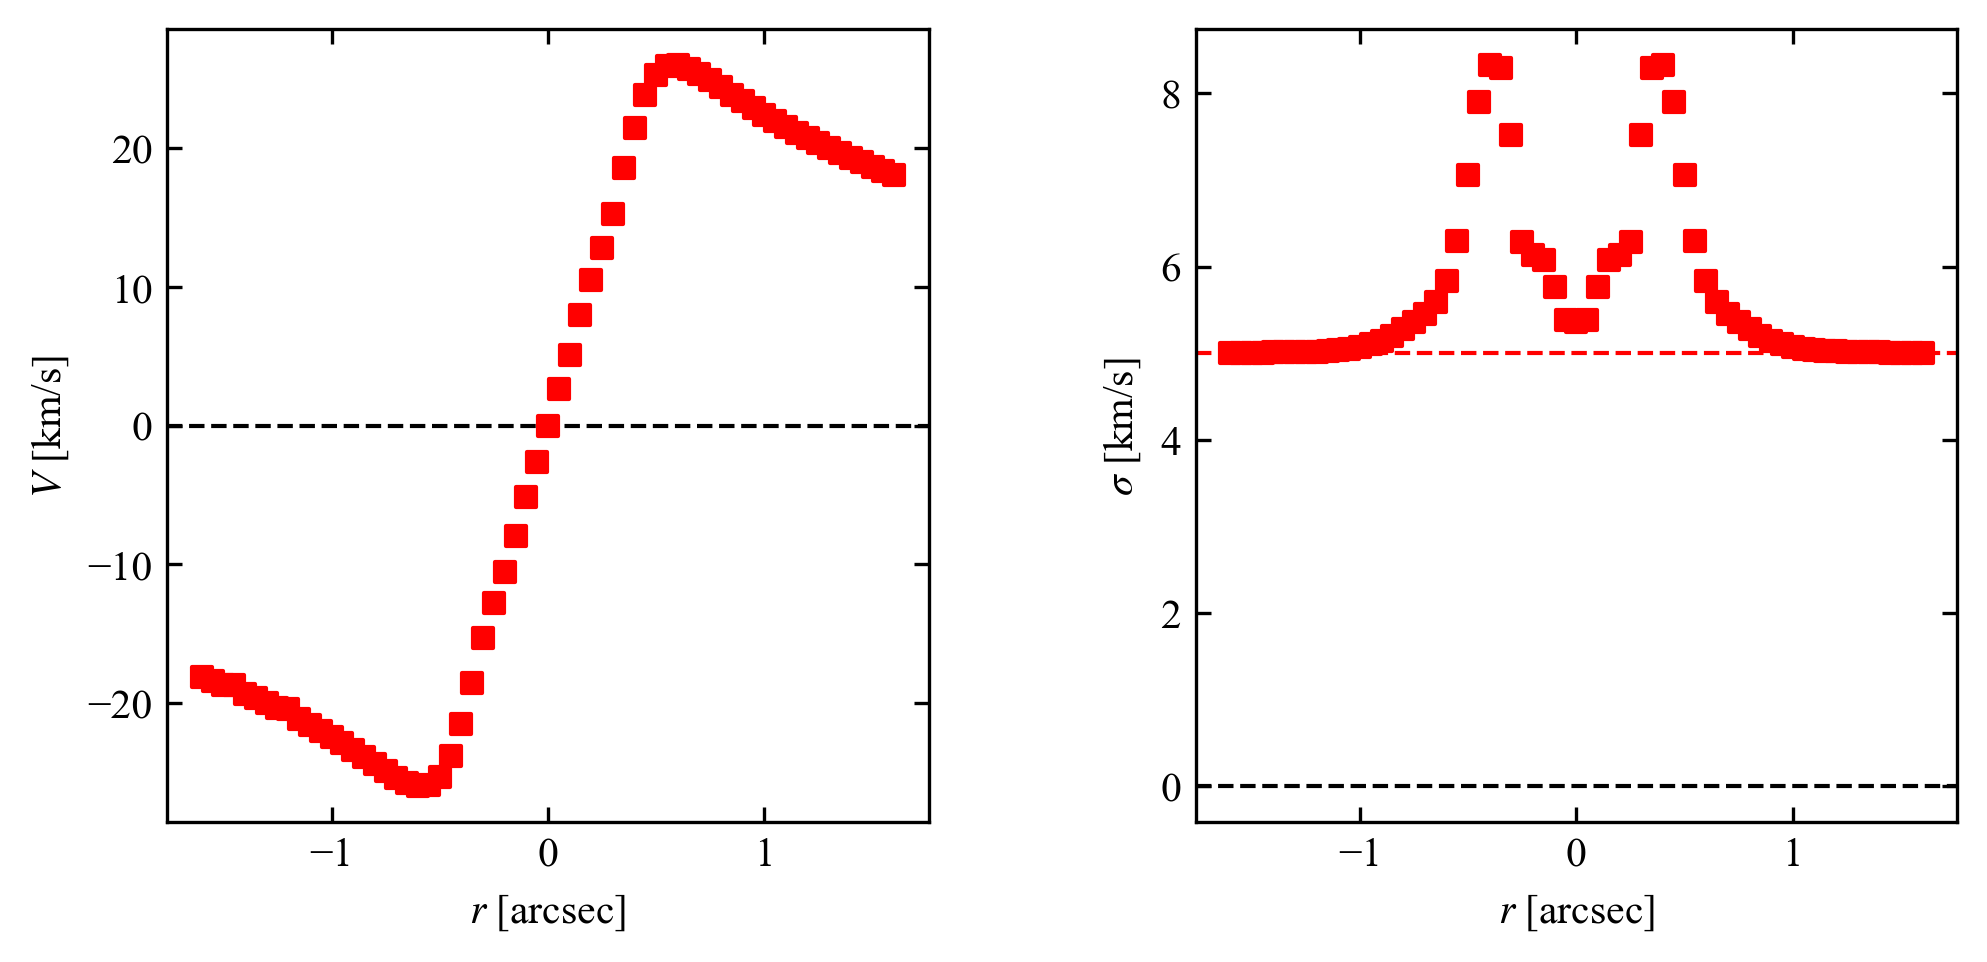

In [70]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [71]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

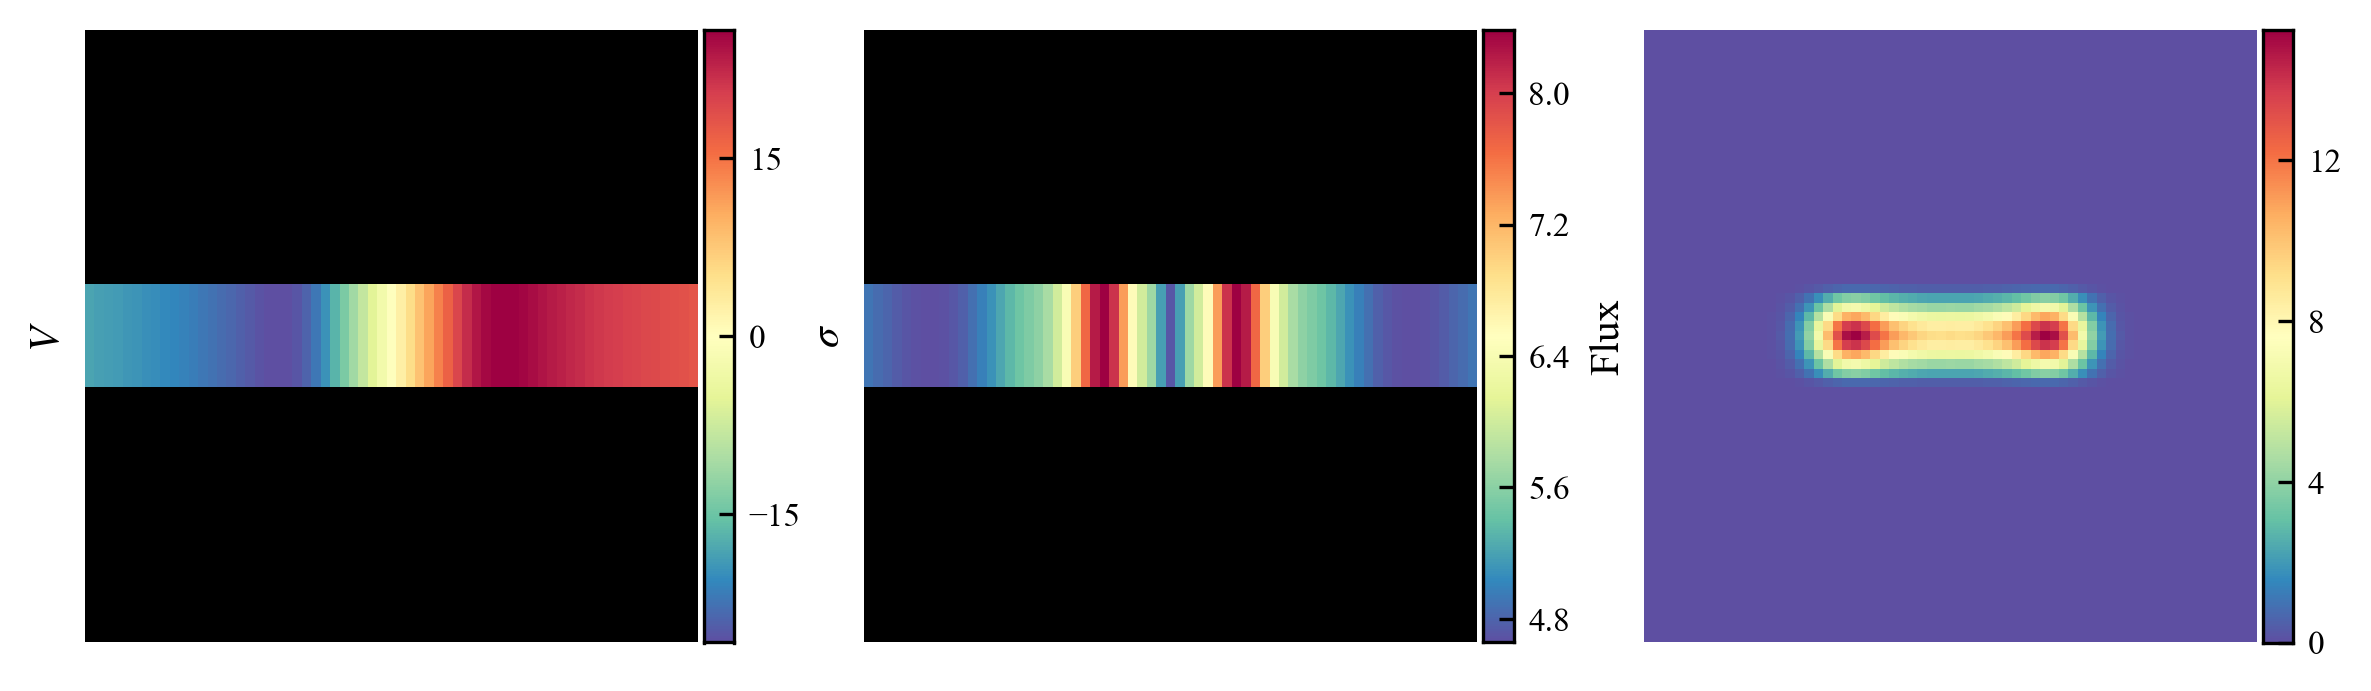

In [72]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [73]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

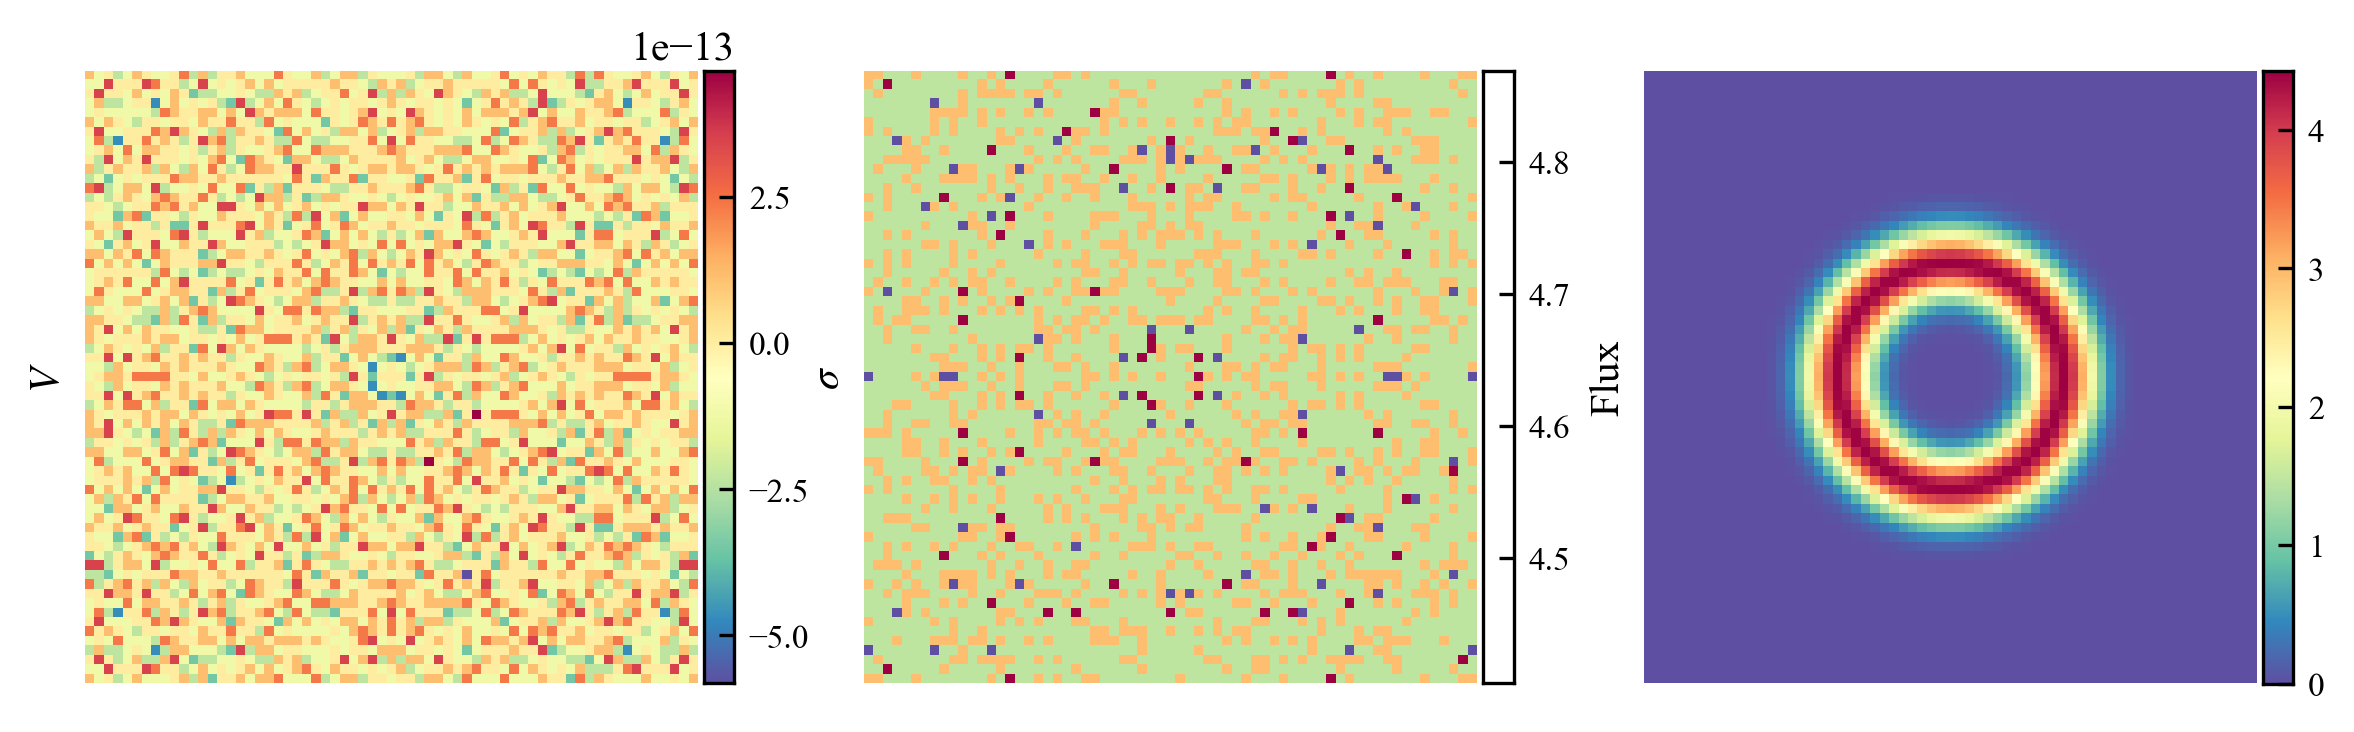

In [74]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------

### Hack 4: Disk+Bulge with LSersic=1, truncated

In [113]:
reload(models)
reload(galaxy)

<module 'dysmalpy.galaxy' from '/Users/sedona/software_public/dysmalpy/dysmalpy/galaxy.py'>

In [114]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [115]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [132]:
galEOnorm = galaxy.Galaxy(z=2., name='galaxy')
mod_setEOnorm = models.ModelSet()
inst = instrument.Instrument()

In [131]:
galFOnorm = galaxy.Galaxy(z=2., name='galaxy')
mod_setFOnorm = models.ModelSet()
inst = instrument.Instrument()

In [116]:
total_mass = 10.5    # M_sun
bt = 0. #bt = 0.3             # Bulge-Total ratio
r_eff_disk = 4.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening
bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge')

TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., 
                                     r_inner=3., r_outer=20., name='TSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [117]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [118]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [119]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [120]:
mod_setFO.add_component(bary)
mod_setFO.add_component(TSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [121]:
mod_setEO.add_component(bary)
mod_setEO.add_component(TSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [133]:
mod_setFOnorm.add_component(bary, light=True)
mod_setFOnorm.add_component(disp_prof)
mod_setFOnorm.add_component(zheight_prof)
mod_setFOnorm.add_component(geomFO)
mod_setFOnorm.kinematic_options.adiabatic_contract = False
mod_setFOnorm.kinematic_options.pressure_support = False

galFOnorm.model = mod_setFOnorm

In [134]:
mod_setEOnorm.add_component(bary, light=True)
mod_setEOnorm.add_component(disp_prof)
mod_setEOnorm.add_component(zheight_prof)
mod_setEOnorm.add_component(geomEO)
mod_setEOnorm.kinematic_options.adiabatic_contract = False
mod_setEOnorm.kinematic_options.pressure_support = False

galEOnorm.model = mod_setEOnorm

In [140]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [141]:
galFO.instrument = inst
galEO.instrument = inst
galFOnorm.instrument = inst
galEOnorm.instrument = inst

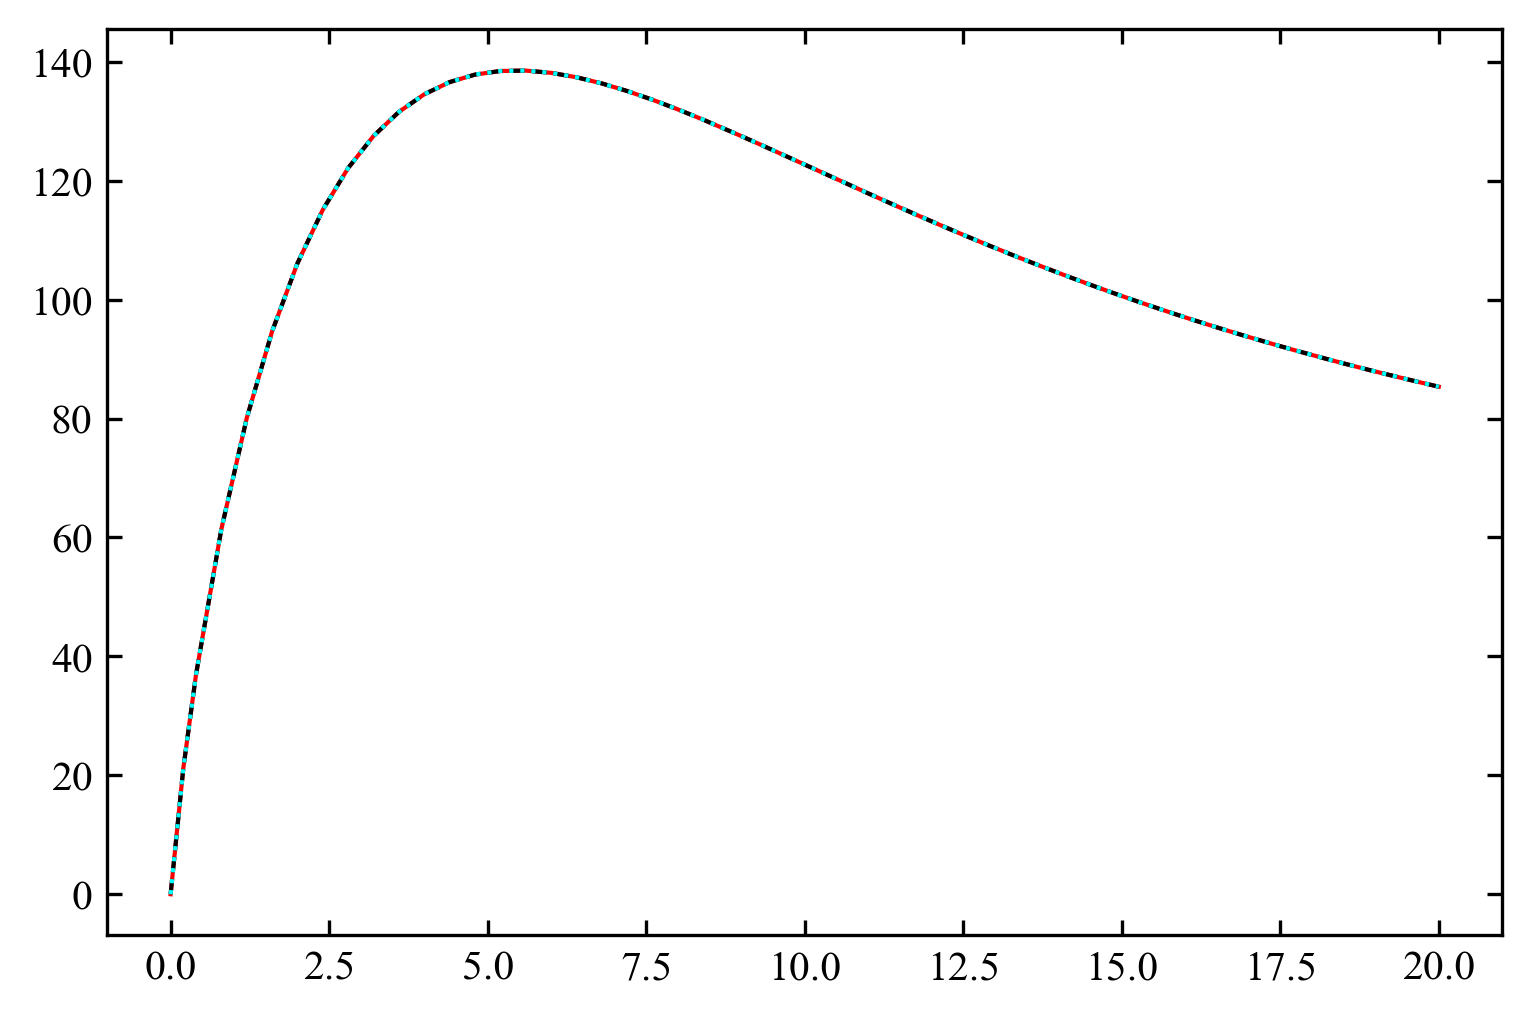

In [142]:
r = np.arange(0.,20.1,0.1)
vc = galEO.model.circular_velocity(r)
vcnorm = galEOnorm.model.circular_velocity(r)
vcbar = bary.circular_velocity(r)
vc[r == 0.] = 0.
vcbar[r==0.] = 0.
plt.plot(r, vcbar, color='red')
plt.plot(r, vc, color='black', ls='--')
plt.plot(r, vcnorm, color='cyan', ls=':')

### 1D model

In [143]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

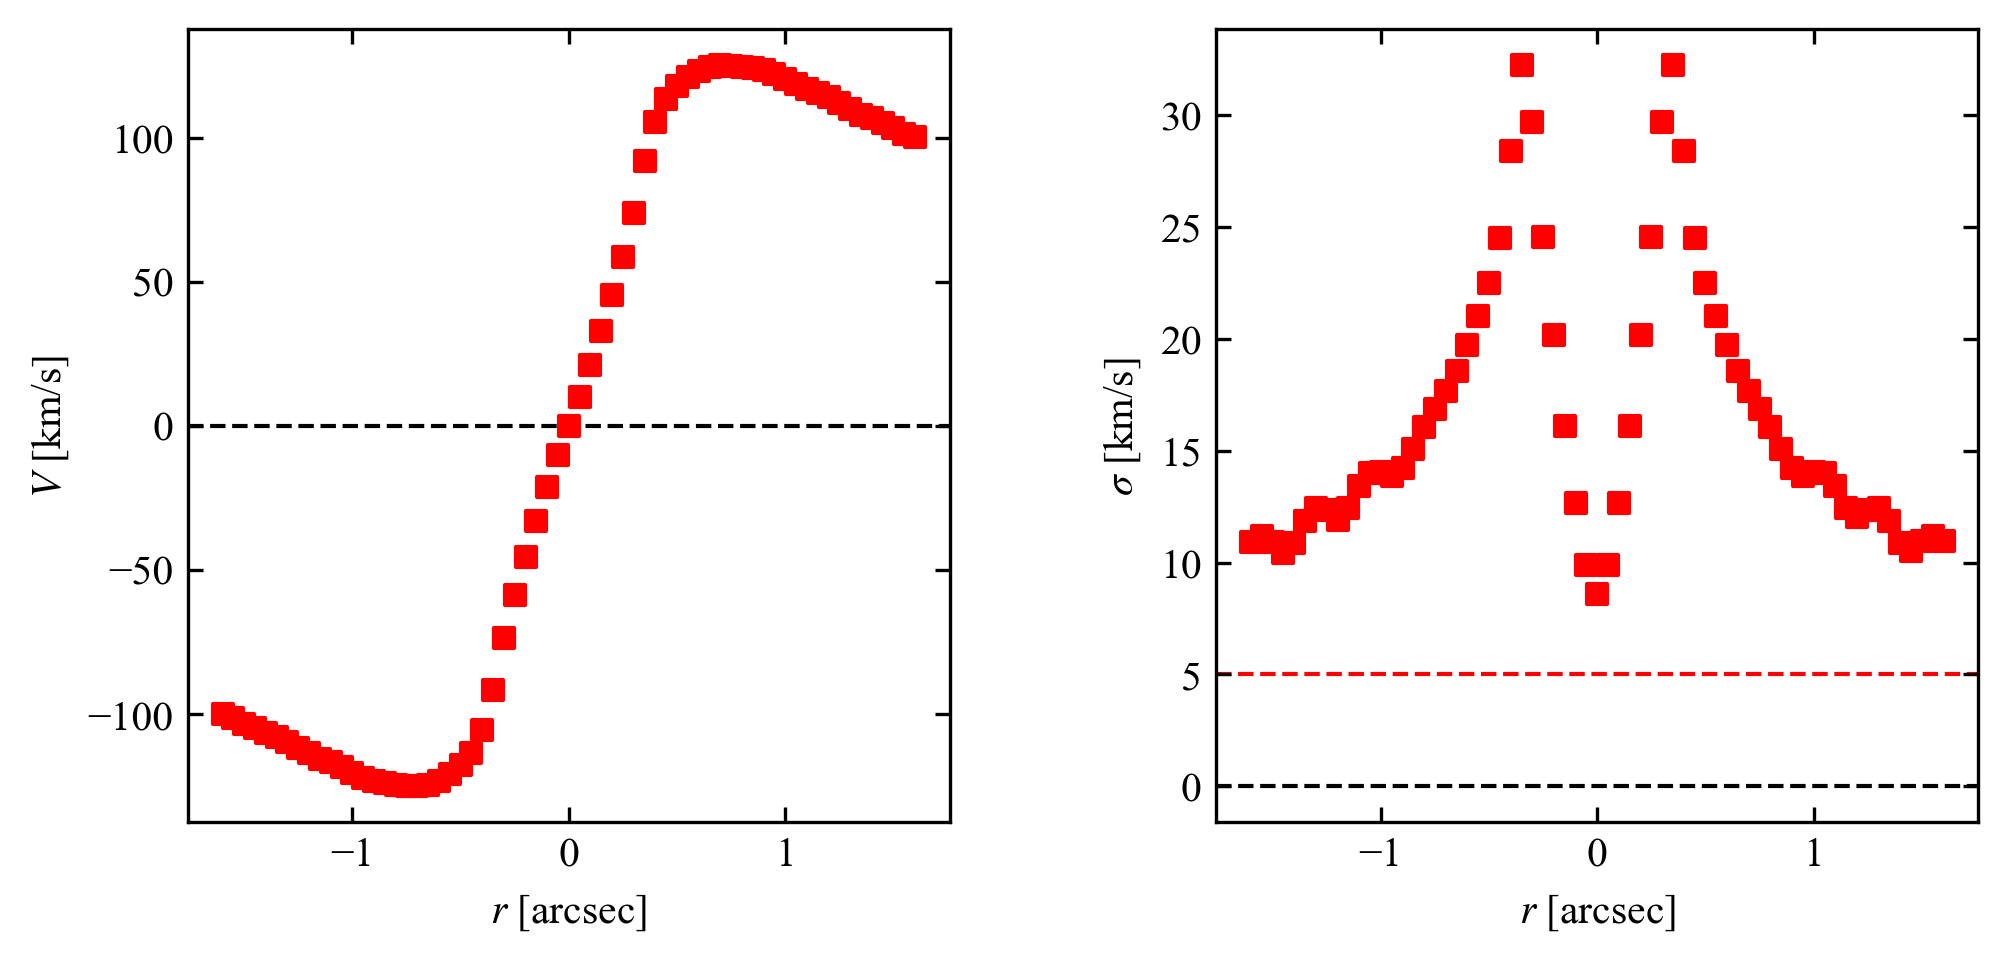

In [144]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

In [145]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEOnorm.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

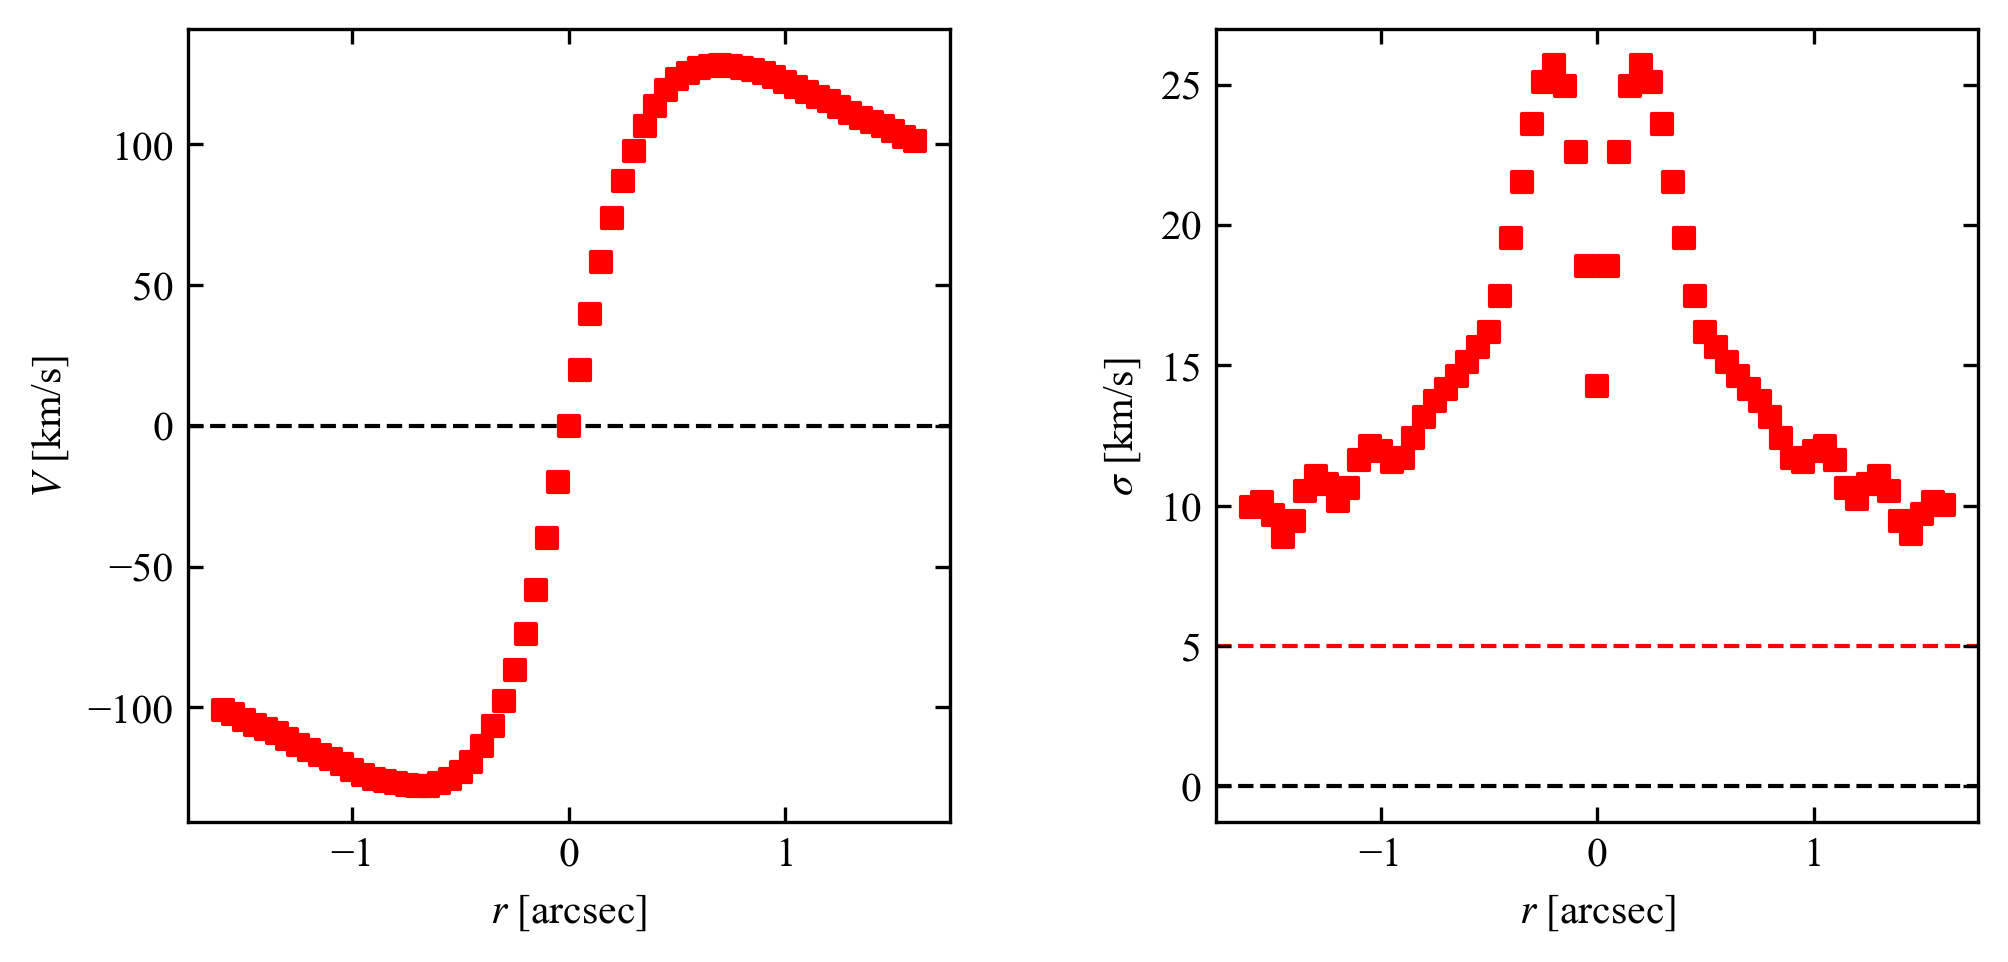

In [146]:
plotting.plot_model_1D(galEOnorm, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [147]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

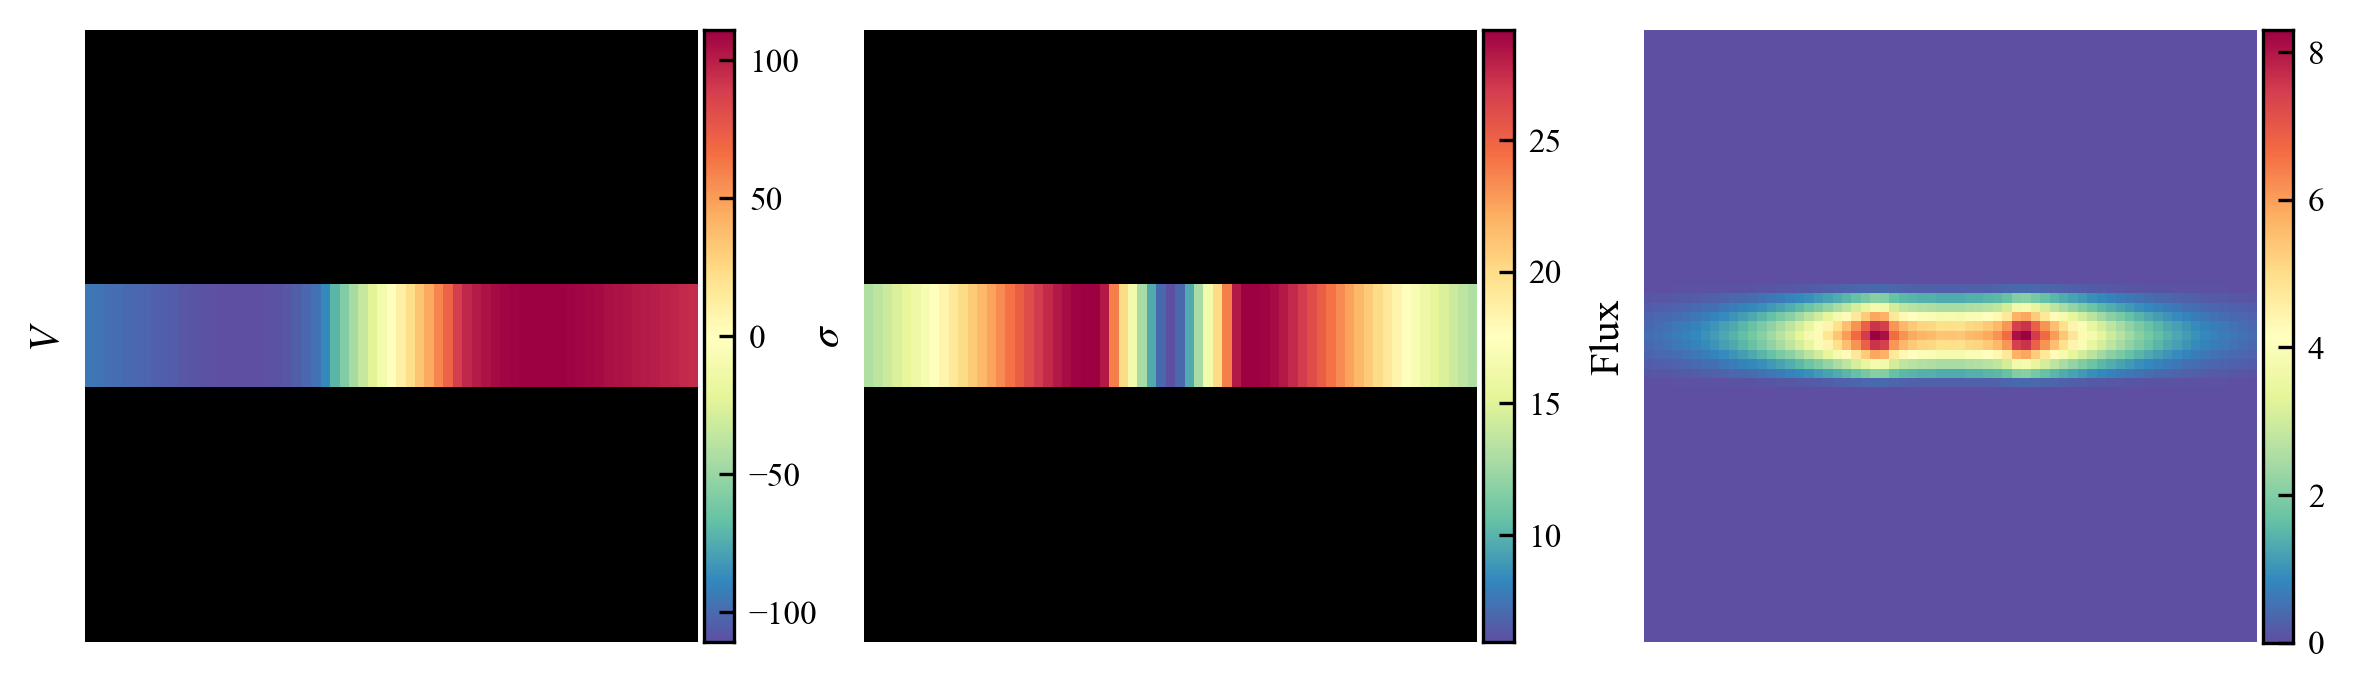

In [148]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

In [149]:
galEOnorm.create_model_data(oversample=3, ndim_final=2, from_data=False)

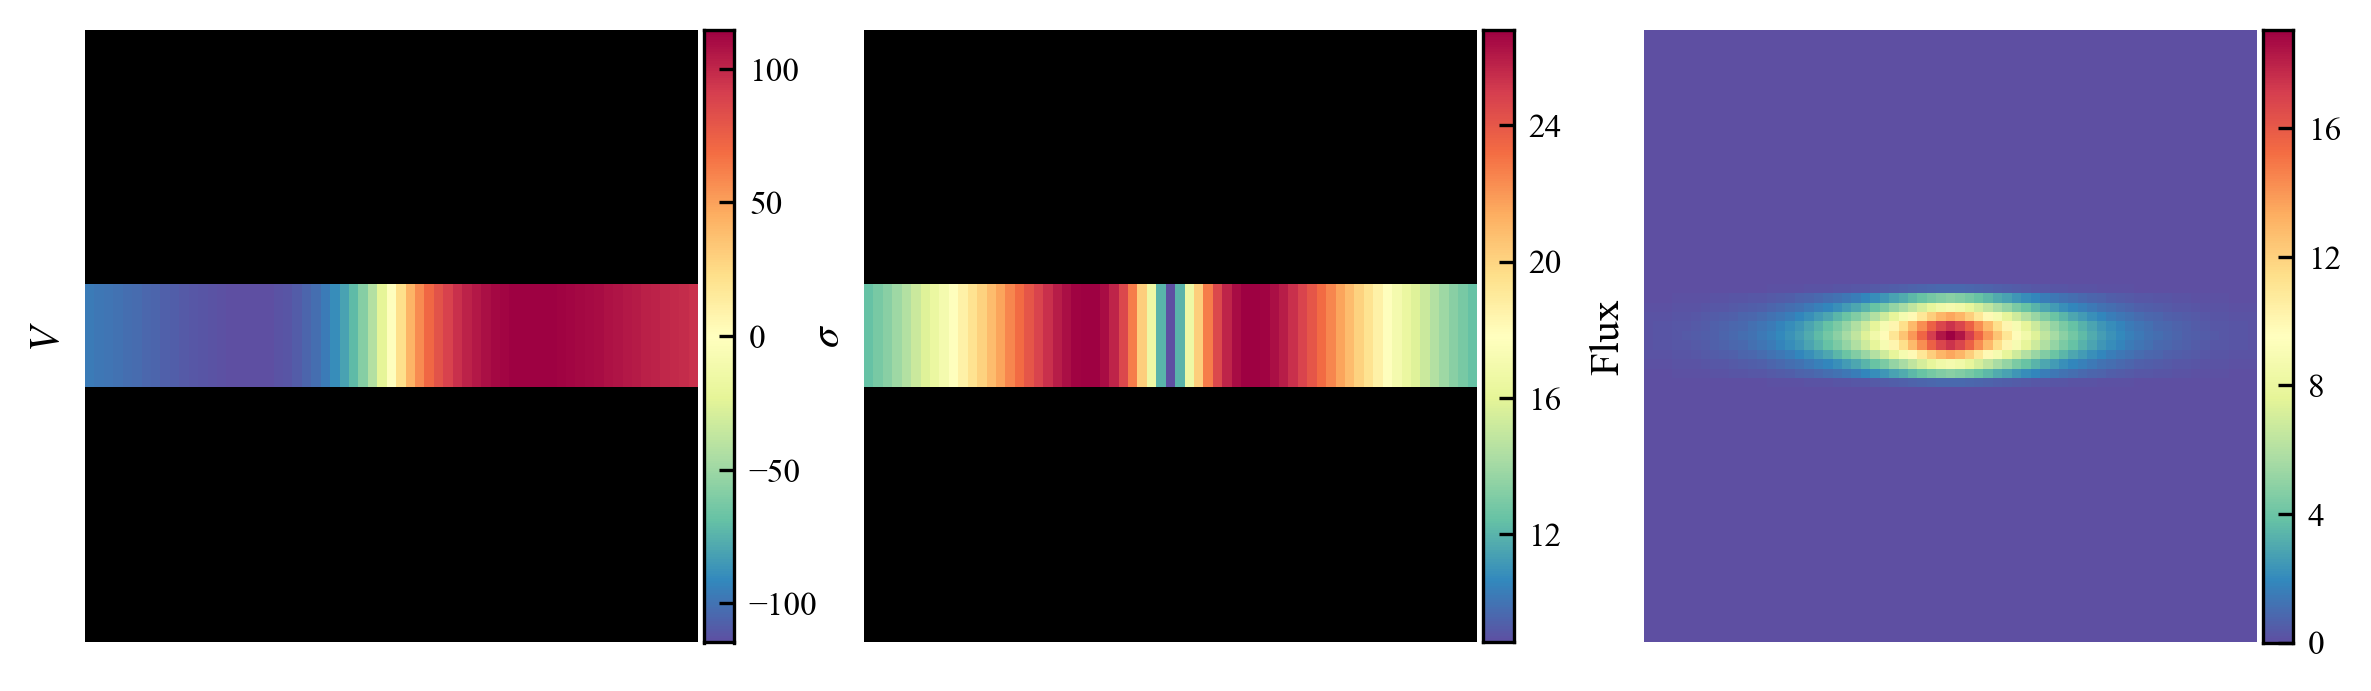

In [150]:
plotting.plot_model_2D(galEOnorm, inst_corr=False, fitflux=True)

### 2D model

In [151]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

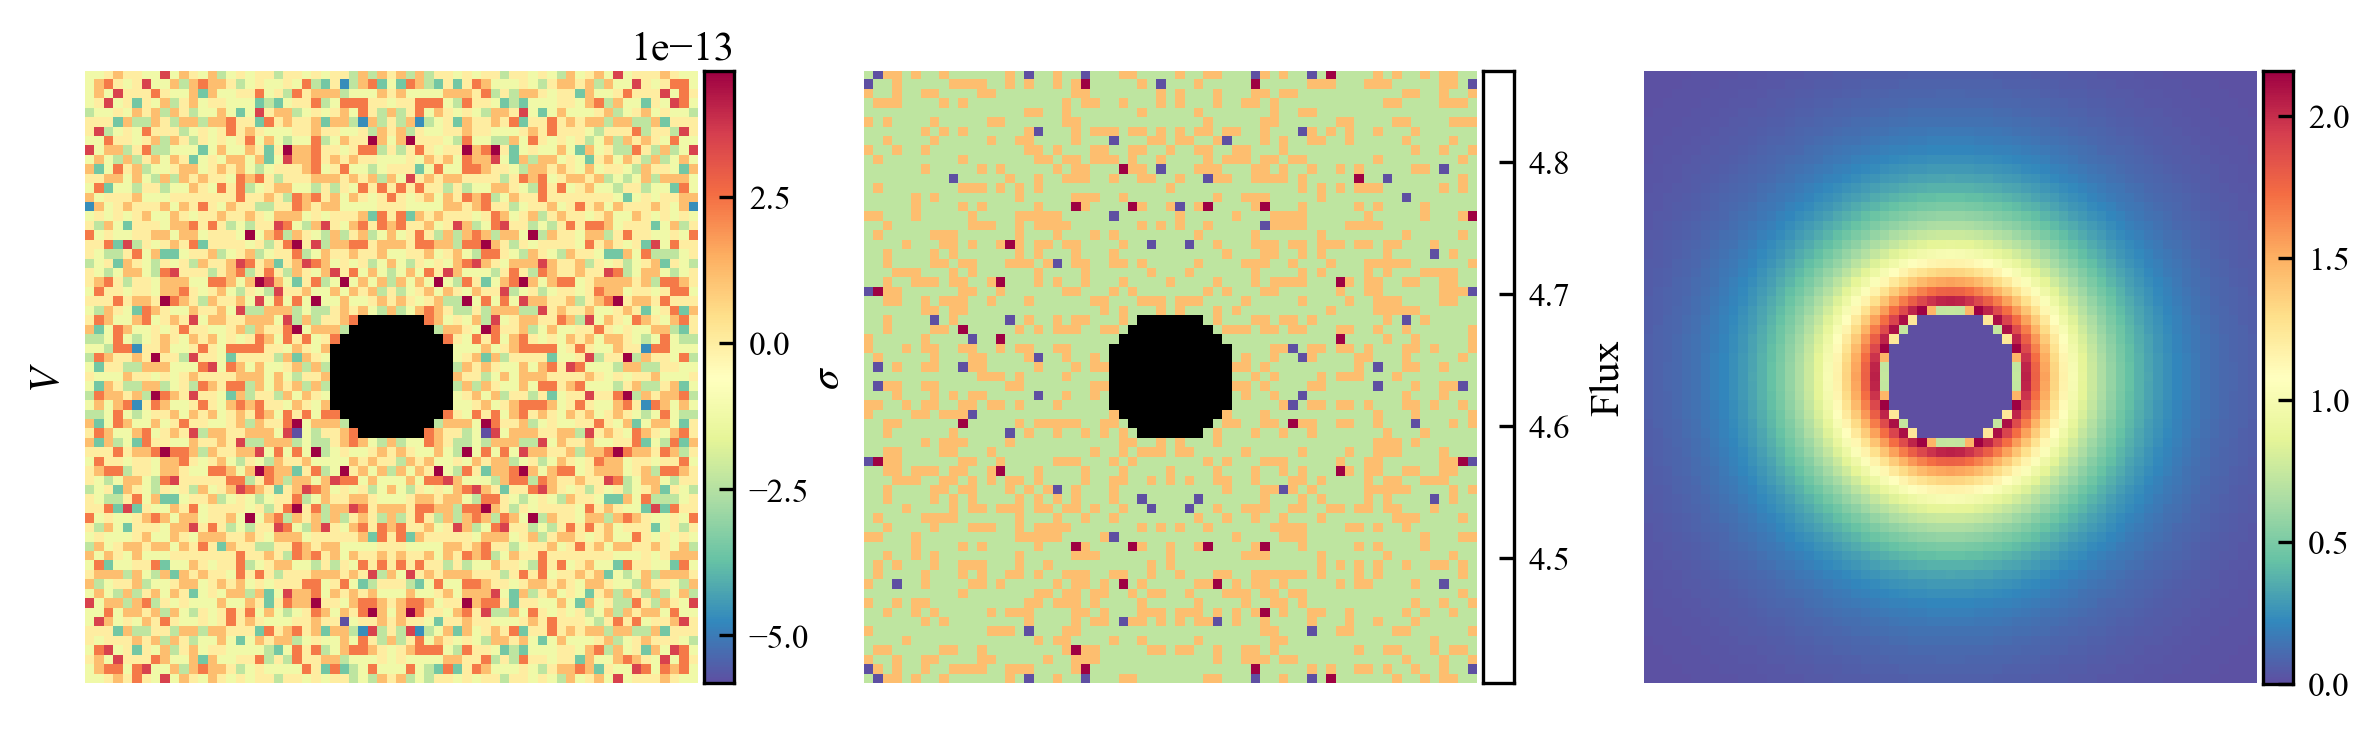

In [152]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

In [153]:
galFOnorm.create_model_data(oversample=3, ndim_final=2, from_data=False)

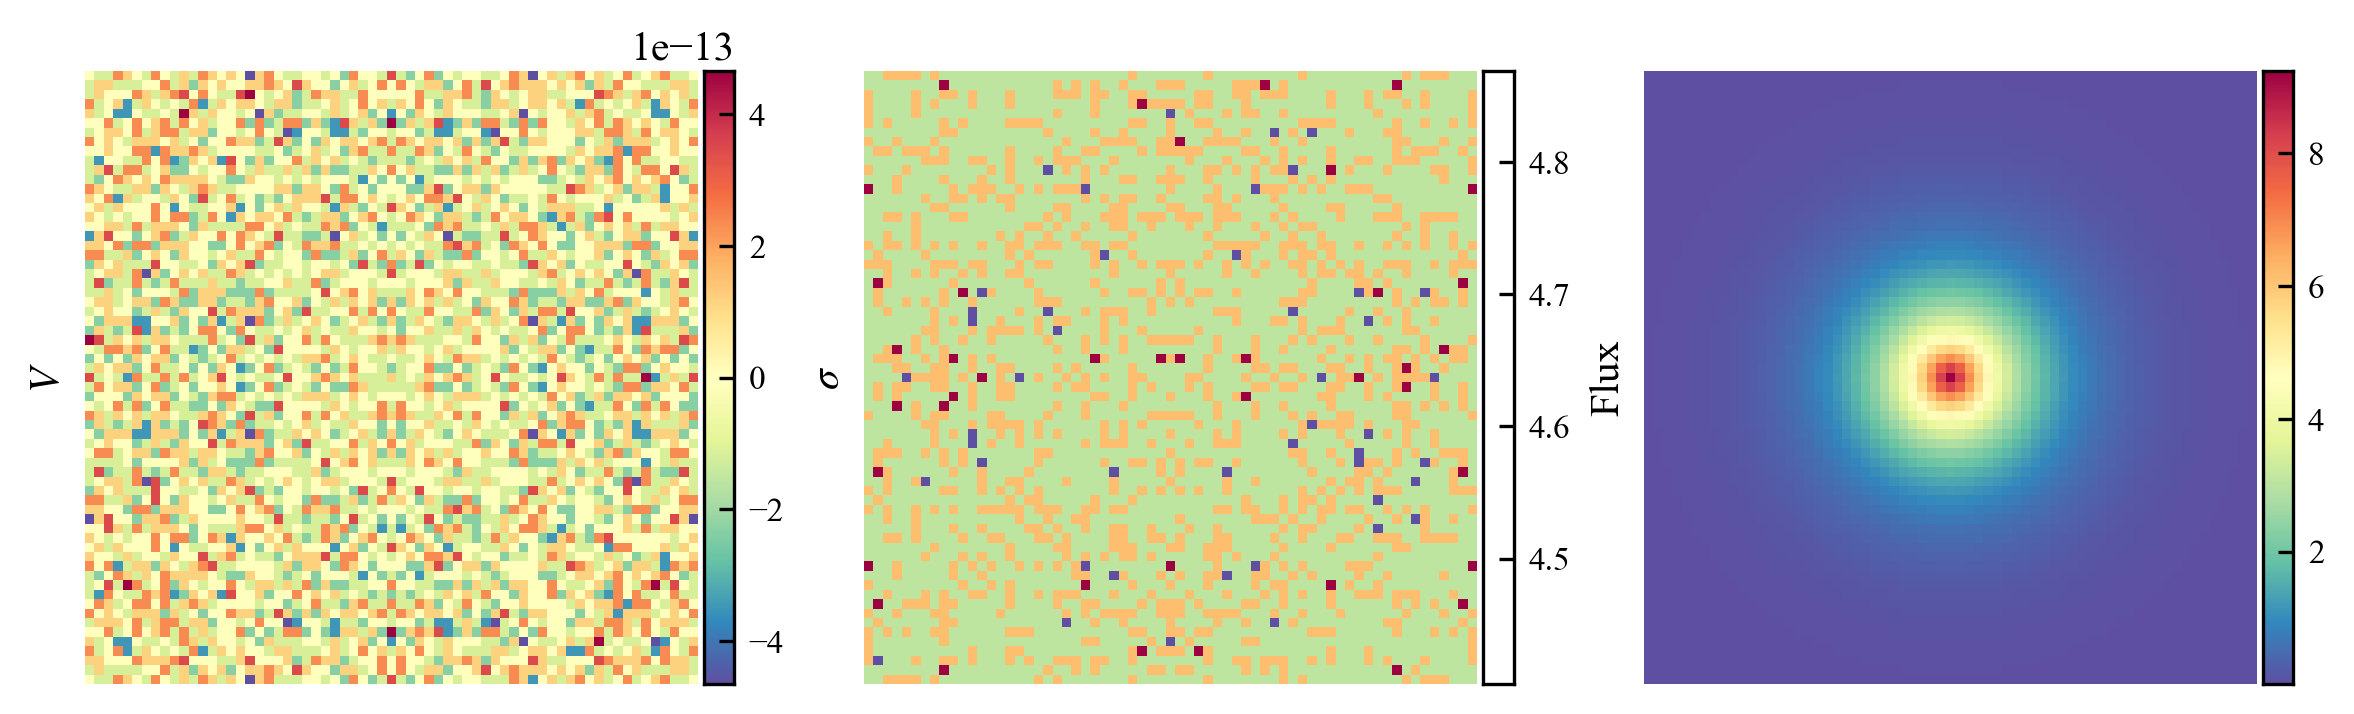

In [154]:
plotting.plot_model_2D(galFOnorm, inst_corr=False, fitflux=True)

---------

--------